# IERG6130 Signal Processing in Wireless Communications and Sensing
## MATLAB Simulation LogBook
| Student Name         | Student ID                |
| :--------------------: | :-------------------------: |
| Han HU  | 1155107763 |

### Raised Cosine Filtering in MATLAB
In this part, we will observe how *Raised Cosine Filtering* will affect the signal.

1. The impulse response

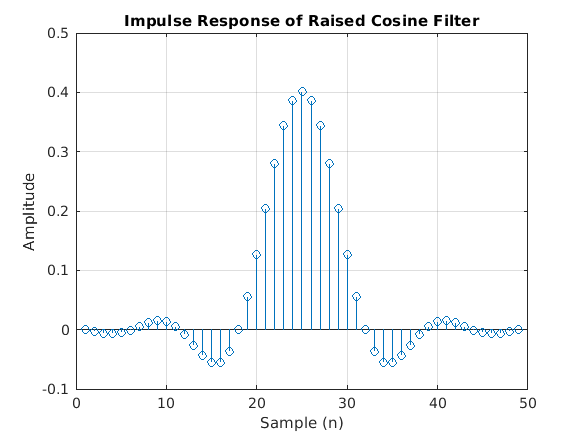

In [6]:
%% parameter settings
Nsym = 6; % FIlter span in symbol duration
beta = 0.5; % Roll-off factor
samplesPerSymbol = 8; % Upsampling factor

%% Define a raised cosine transimitter filter
rcfFilt = comm.RaisedCosineTransmitFilter(...
    'RolloffFactor',beta,...
    'FilterSpanInSymbols',Nsym,...
    'OutputSamplesPerSymbol',samplesPerSymbol);
% Visualize a impulse response
% fvtool(rcfFilt,'Analysis','impulse')

%% Alternative to `fvtool`
% Get filter coefficients
filterCoeffs = coeffs(rcfFilt);
% Calculate impulse response
impulseResponse = filterCoeffs.Numerator;
% Create stem plot of impulse response
stem(impulseResponse);
xlabel('Sample (n)');
ylabel('Amplitude');
title('Impulse Response of Raised Cosine Filter');
grid on;



In [7]:
% Normalize to obtain maximum filter tap value of 1
rcfFilt.Gain = 1/max(filterCoeffs.Numerator);


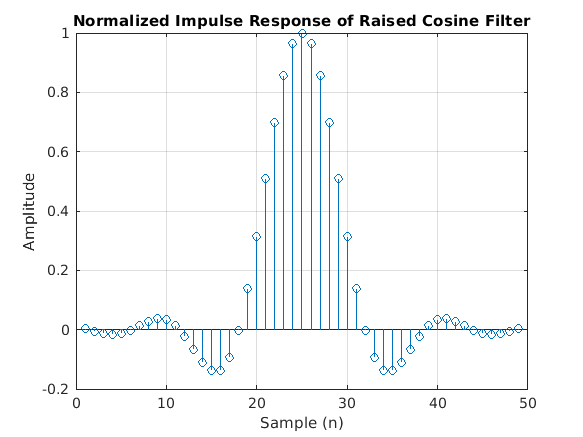

In [8]:
% Visualize the impulse response after normalization
% fvtool(rcfFilt,'Analysis','impulse')

%% Alternative to `fvtool`
% Get filter coefficients
filterCoeffs_normalized = coeffs(rcfFilt);
% Calculate impulse response
impulseResponse = filterCoeffs_normalized.Numerator;
% Create stem plot of impulse response
stem(impulseResponse);
xlabel('Sample (n)');
ylabel('Amplitude');
title('Normalized Impulse Response of Raised Cosine Filter');
grid on;


2. Pulse shaping with raised cosine filter

        A bipolar data sequence is generated.

        No ISI is introduced.   

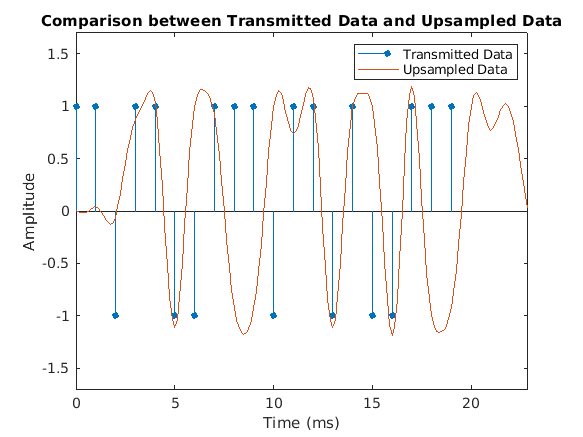

In [10]:
%% Pulse shaping with raised cosine filter
% Bipolar data sequence with no ISI

% Parameters
DataL = 20; % Data length in symbols
R = 1000; % Data rate in symbols per second
Fs = R * samplesPerSymbol; % Sampling frequency in Hz

% Create a local random stream to be used by random number generators for repeatability
hStr = RandStream('mt19937ar','Seed',0);

% Generate random data
data = 2*randi(hStr,[0 1],DataL,1) - 1;
% Time vector sampled at symbol rate in milliseconds
t = (0:DataL-1)/R*1000;

% The plot compares the digital data and the interpolated signal. 
% It is difficult to compare the two signals because the peak response of 
% the filter is delayed by the group delay of the filter (Nsym/(2*R)). 
% Note that we append Nsym/2 zeros at the end of input x to 
% flush all the useful samples out of the filter.

% Filter
yo = rcfFilt([data; zeros(Nsym/2,1)]);
% Time vector sampled at sampling frequency in milliseconds
to = (0:(DataL+Nsym/2)*samplesPerSymbol-1)/Fs*1000;
% Plot data
fig1 = figure;
stem(t,data,'filled','MarkerSize',4);
hold on;
% Plot filtered data
plot(to,yo,'LineWidth',1);
hold off;
% set axes and labels
axis([0 to(end) -1.7 1.7]);
xlabel('Time (ms)');
ylabel('Amplitude');
legend('Transmitted Data','Upsampled Data');
title('Comparison between Transmitted Data and Upsampled Data');

3. Compensation for Group Delay

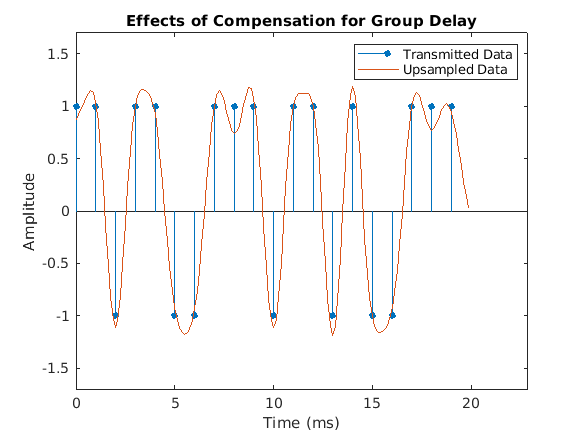

In [11]:
% This step compensates for the raised cosine filter group delay by 
% delaying the input signal. Now it is easy to see how the raised cosine filter 
% upsamples and filters the signal. The filtered signal is identical to 
% the delayed input signal at the input sample times. This shows 
% the raised cosine filter capability to band-limit the signal while avoiding ISI.

% Filter group delay, since raised cosine filter is linear phase and symmetric.
fltDelay = Nsym/(2*R);
% Correct for propagation delay by removing filter transients
y1 = yo(fltDelay*Fs+1:end);
t1 = (0:DataL*samplesPerSymbol-1)/Fs*1000;
% Plot data
fig2 = figure;
stem(t,data,'filled','MarkerSize',4);
hold on;
plot(t1,y1,'LineWidth',1);
hold off;
% set axes and labels
axis([0 to(end) -1.7 1.7]);
xlabel('Time (ms)');
ylabel('Amplitude');
legend('Transmitted Data','Upsampled Data');
title('Effects of Compensation for Group Delay');

4. Different roll factor $\beta$ 

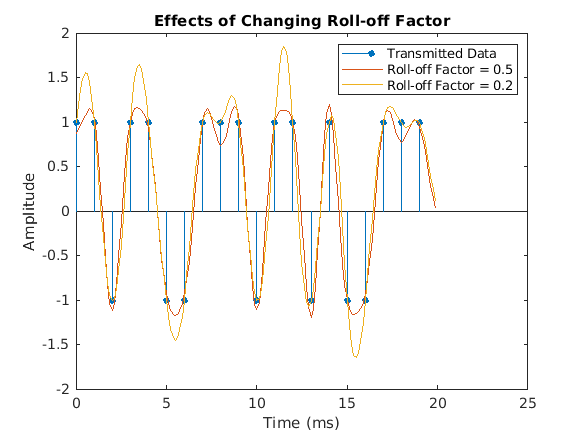

In [15]:
%% Roll-off factor
% This step shows the effect that changing the roll-off factor from .5 (blue curve)
% to .2 (red curve) has on the resulting filtered output. The lower value for 
% roll-off causes the filter to have a narrower transition band 
% causing the filtered signal overshoot to be greater for the red curve 
% than for the blue curve.

% set the roll factor to 0.2
rctFilt2 = comm.RaisedCosineTransmitFilter(...
    'Shape','Normal',...
    'RolloffFactor',0.2,...
    'FilterSpanInSymbols',Nsym,...
    'OutputSamplesPerSymbol',samplesPerSymbol);
% Normalize to obtain maximum filter tap value of 1
b = coeffs(rctFilt2);
rctFilt2.Gain = 1/max(b.Numerator);
% Filter
y2 = rctFilt2([data; zeros(Nsym/2,1)]);
% Correct for propagation delay by removing filter transients
y2 = y2(fltDelay*Fs+1:end);
% Plot data
fig3 = figure;
stem(t,data,'filled','MarkerSize',4);
hold on;
% plot filtered data
plot(t1,y1,'LineWidth',1);
plot(t1,y2,'LineWidth',1);
hold off;
% set axes and labels
axis([0 25 -2 2]);
xlabel('Time (ms)');
ylabel('Amplitude');
legend('Transmitted Data','Roll-off Factor = 0.5','Roll-off Factor = 0.2');
title('Effects of Changing Roll-off Factor');

5. Square-Root Raised Cosine Filters

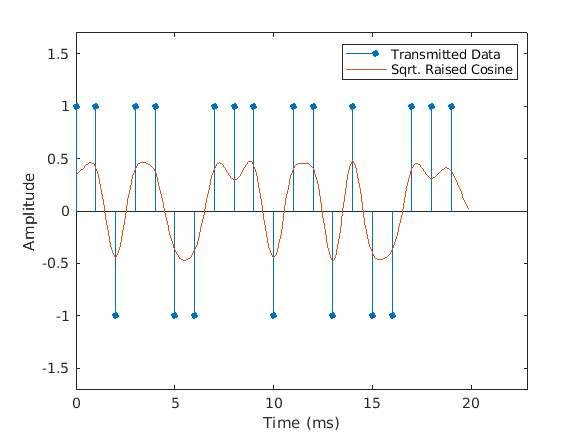

In [29]:
%% Square-Root Raised Cosine Filters
% A typical use of raised cosine filtering is to split the filtering between transmitter and receiver. Both transmitter and receiver employ square-root raised cosine filters. The combination of transmitter and receiver filters is a raised cosine filter, which results in minimum ISI. We specify a square-root raised cosine filter by setting the shape as 'Square root'.

% Design raised cosine filter with given order in symbols
rctFilt3 = comm.RaisedCosineTransmitFilter(...
    'Shape','Square root',...
    'RolloffFactor',beta,...
    'FilterSpanInSymbols',Nsym,...
    'OutputSamplesPerSymbol',samplesPerSymbol);

% The data stream is upsampled and filtered at the transmitter using the designed filter. This plot shows the transmitted signal when filtered using the square-root raised cosine filter.

% Upsample the filter
y3 = rctFilt3([data; zeros(Nsym/2,1)]);
% Correct for propagation delay by removing filter transients
y3 = y3(fltDelay*Fs+1:end);
% Plot data
fig4 = figure;
stem(t,data,'filled','MarkerSize',4);
hold on;
% Plot filtered data
plot(t1,y3,'LineWidth',1);
hold off;
% set axes and labels
axis([0 to(end) -1.7 1.7]);
xlabel('Time (ms)');
ylabel('Amplitude');
legend('Transmitted Data','Sqrt. Raised Cosine');

    The filtered received signal should look like

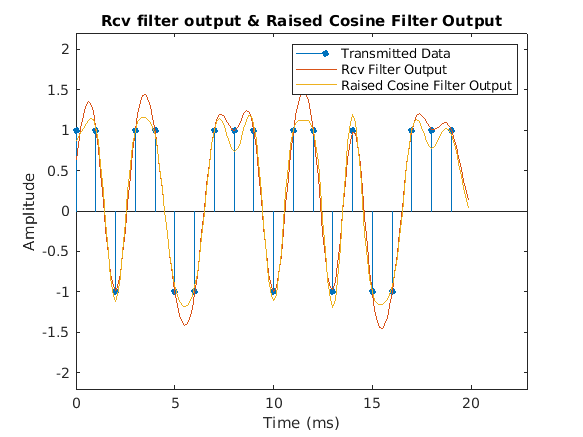

In [26]:
%The transmitted signal (magenta curve) is then filtered at the receiver. We did not decimate the filter output to show the full waveform. The default unit energy normalization ensures that the gain of the combination of the transmit and receive filters is the same as the gain of a normalized raised cosine filter. The filtered received signal, which is virtually identical to the signal filtered using a single raised cosine filter, is depicted by the blue curve at the receiver.

% Design raised cosine filter with given order in symbols
rcrFilt = comm.RaisedCosineReceiveFilter(...
    'Shape','Square root',...
    'RolloffFactor',beta,...
    'FilterSpanInSymbols',Nsym,...
    'InputSamplesPerSymbol',samplesPerSymbol,...
    'DecimationFactor',1);
% Filter at the receiver
yr = rcrFilt([y3; zeros(Nsym*samplesPerSymbol/2,1)]);
% Correct for propagation delay by removing filter transients
yr = yr(fltDelay*Fs+1:end);
% Plot data
fig5 = figure;
stem(t,data,'filled','MarkerSize',4);
hold on;
% Plot filtered data
plot(t1,yr,'LineWidth',1);
plot(t1,y1,'LineWidth',1);
hold off;
% set axes and labels
axis([0 to(end) -2.2 2.2]);
xlabel('Time (ms)');
ylabel('Amplitude');
legend('Transmitted Data','Rcv Filter Output', ...
    'Raised Cosine Filter Output');
title('Rcv filter output & Raised Cosine Filter Output');

6. Computational Cost

In [30]:
%% Computational Cost
% In the following table, we compare the computational cost of 
% a polyphase FIR interpolation filter and polyphase FIR decimation filter.
C1 = cost(rctFilt3)
C2 = cost(rcrFilt)

C1 = struct with fields:
   NumCoefficients: 49
                        NumStates: 6
    MultiplicationsPerInputSample: 49
          AdditionsPerInputSample: 41

C2 = struct with fields:
   NumCoefficients: 49
                        NumStates: 48
    MultiplicationsPerInputSample: 49
          AdditionsPerInputSample: 48

### Passband Modulation
In this part, a **Simulink** model is used to observe the basic *Passband Modulation*.

1. The overview of the simulink model
![Passband](resources/PassbandModulationExample_01.png)

In [47]:
%% Passband Modulation
% This model shows a straightforward way to perform passband modulation, by
% multiplying a modulated complex signal with a complex sine wave to
% perform frequency upconversion.  In general, it is preferable to model a
% system at complex baseband.  However, there are some circumstances where
% it is necessary to model the system at real passband. An example of this
% is when an adjacent band signal is processed with a nonlinearity, and
% causes interference in the desired band. This model also illustrates the
% effect of such interference.


%%
clc
clear
close all
% dbstop in PassbandModulationExample at 90
% dbstop in PassbandModulationExample at 104
% 
%%
modelname = '~/IERG6130-simulation/modules/commpassbandmod';
open_system(modelname);
desint   = sprintf([modelname ...
    '/Upconverted\nSpectra/Desired Signal and\nInterference']);
downconv = sprintf([modelname '/Downconverted\nComplex Signal']);
const    = [modelname '/Received Constellation'];

% Set scope visibility
% close_system(desint);
set_param(desint, 'OpenScopeAtSimStart', 'off');
% close_system(downconv);
set_param(downconv, 'OpenScopeAtSimStart', 'off');
% close_system(const);
set_param(const, 'openScopeAtSimStart', 'off');
commpassbandmod([], [], [], 'compile');
commpassbandmod([], [], [], 'term');

%% Structure of the Example
%
% The communications link in this model includes these components:
%
% * A |Random Integer Generator| block, used as source of random data
% * A modulator and a pulse shaping filter that perform QPSK modulation and
% root
%   raised cosine pulse shaping.
% * An |Upconverter| block that multiplies the modulated signal by a
% carrier
%   frequency.
% * A source of tone interference.  The interference has a cubic
% nonlinearity
%   which may be toggled on or off.  When the nonlinearity is off, the
%   interference falls completely out of band, but when on, the third
%   harmonic of the tone is introduced into the desired band, causing
%   co-channel interference.
% * An |AWGN Channel| block, set to Eb/No mode.  It specifies two bits per
%   symbol because the modulation format is QPSK.  The signal power is
%   1/(2*8) watts. This is because the original signal power at the
%   modulator is 1 watt. The root-raised cosine filter upsamples the signal
%   by a factor of 8, which reduces the power by that factor.  The
%   frequency upconversion block output takes only the real part of the
%   signal, thereby reducing the power again, this time by a factor of 2.
%   Finally, the symbol period is 1e-6 seconds, to match the original
%   sample time on the |Random Integer Generator| source.
% * A |Downconverter| block that converts the signal from real passband to
%   complex baseband.
% * A root raised cosine pulse shaping filter that decimates back to one
% sample
%   per symbol, and a QPSK demodulator block.
% * BER and RMS EVM metric calculation blocks.

'~' is not a valid model name because it is not a valid MATLAB function name.

So the above code is using Simulink and visualize such results in Jupyter Notebook is not straightforward. In this case, I will try to screenshot the results and include them here.


In [ ]:
%% Results and Displays
% When the simulation runs, two spectrum analyzers and one scatter plot
% open.
%
% The first spectrum analyzer shows the signal and the interference signal
% at passband.  With the nonlinearity turned off, the spectrum of the tone
% interferer falls outside the bandwidth of the desired signal.  With the
% cubic nonlinearity on, the third harmonic of the interference falls into
% the band of the desired signal.

open_system(desint);
set_param(desint, 'OpenScopeAtSimStart', 'on');
sim(modelname);
disp('The first spectrum analyzer result')


Nonlinearity turned off
<p float = "left">
    <!-- <img src="results/1-linear-spectrum.png" width="90%" /> -->
    <img src="results/1-linear-noise-signal.png" width="90%" />
    <!-- <img src="results/1-linear-constellation.png" width="30%"/> -->
</p>

Turned on
<p float = "left">
    <!-- <img src="results/1-non-linear-spectrum.png" width="90%" /> -->
    <img src="results/1-non-linear-noise-signal.png" width="90%" />
    <!-- <img src="results/1-nonlinear-constellation.png" width="30%"/> -->
</p>


In [ ]:
%%
% The second scope illustrates the signal after it has been downconverted
% back to baseband at the receiver, prior to the root raised cosine
% filtering.  Note that with the nonlinearity on, you can see the
% interfering tone present with the baseband signal.

% close_system(desint);
set_param(desint, 'OpenScopeAtSimStart', 'off');
open_system(downconv);
set_param(downconv, 'OpenScopeAtSimStart', 'on');
sim(modelname);
disp('The second scope result')

Nonlinearity turned off
<p float = "left">
    <!-- <img src="results/1-linear-spectrum.png" width="90%" /> -->
    <img src="results/2-sp.png" width="90%" />
    <!-- <img src="results/1-linear-constellation.png" width="30%"/> -->
</p>

Turned on
<p float = "left">
    <!-- <img src="results/1-non-linear-spectrum.png" width="90%" /> -->
    <img src="results/2-sp-non.png" width="90%" />
    <!-- <img src="results/1-nonlinear-constellation.png" width="30%"/> -->
</p>


In [ ]:
%%
% The third scope shows the scatter plot of the received signal, and by
% toggling the nonlinearity on and off, you can view the effect the
% interference has on the scatter plot.  With the nonlinearity on, the
% signal constellation is more diffuse than when the nonlinearity is not
% present.

%%
% close_system(downconv);
set_param(downconv, 'OpenScopeAtSimStart', 'off');
open_system(const);
set_param(const, 'openScopeAtSimStart', 'on');
sim(modelname);
disp('The third scope result')

Nonlinearity turned off
<p float = "left">
    <!-- <img src="results/1-linear-spectrum.png" width="90%" /> -->
    <img src="results/3-con.png" width="90%" />
    <!-- <img src="results/1-linear-constellation.png" width="30%"/> -->
</p>

Turned on
<p float = "left">
    <!-- <img src="results/1-non-linear-spectrum.png" width="90%" /> -->
    <img src="results/3-non-con.png" width="90%" />
    <!-- <img src="results/1-nonlinear-constellation.png" width="30%"/> -->
</p>


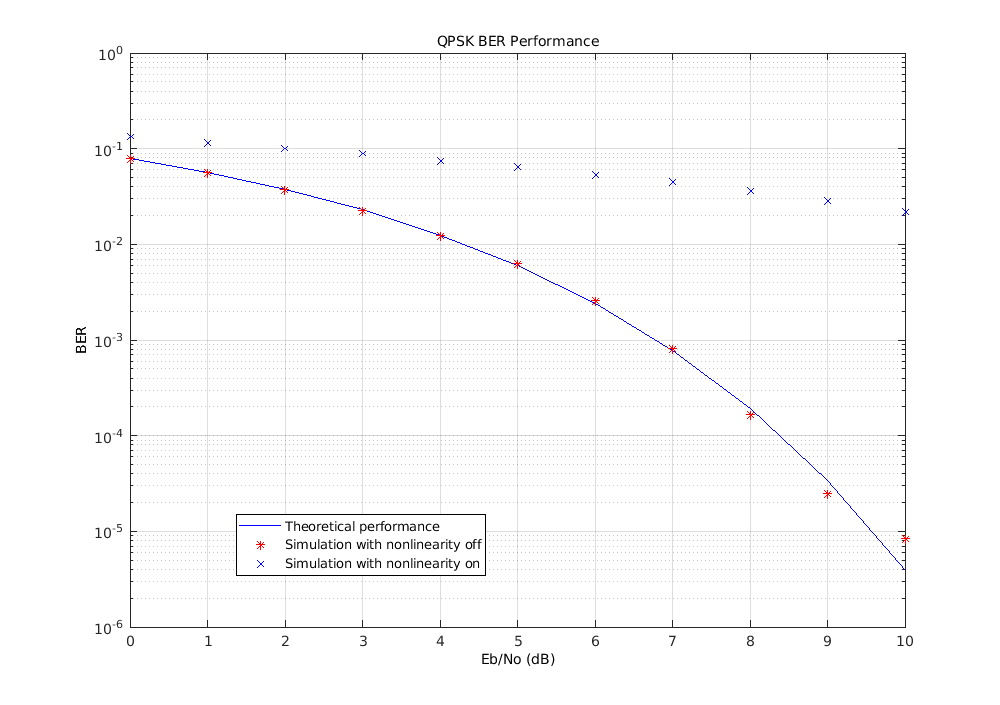

In [46]:
%%
% The model also contains two numerical displays. The first one displays
% the BER of the link. The BER calculation resets each time the
% nonlinearity is toggled on or off.
%
% The second numerical display is the RMS Error Vector Magnitude (EVM)
% measured with the <docid:comm_ref#br3a9d8 EVM Measurement> block.

%% Experimenting with the Example
%
% Double-click on the |Nonlinearity on/off| block to toggle the
% nonlinearity on the interference signal.  Observe the changes this has on
% the received spectrum, constellation, BER and EVM.
%
% By varying the Eb/No parameter, you can produce BER curves, and compare
% the results of the model with theoretical results. Note that the model
% achieves expected theoretical results[ <#10 1> ] for QPSK with the
% nonlinearity off. Furthermore, you can see the effects the nonlinearity
% has on overall BER.
%
% For further experimentation, try changing the value of the Eb/No
% parameter on the AWGN channel block, or changing the power of the
% interference signal. To change the power of the interference signal, open
% the |Interference with Nonlinearity| subsystem, and modify the gain
% value.

hFig = open('~/IERG6130-simulation/results/commpassbandmod_BER.fig');

% exportgraphics(hFig,'results/commpassbandmod_BER.png');

% close(hFig);

% figure;
% imshow('results/commpassbandmod_BER.png');

%% See Also
%
% The |Downconverter| block uses a simple complex multiplication method to
% perform downconversion. You can find an example showing more efficient
% downconversion using IF subsampling at:
% <docid:dsp_ug#example-ifsubsamplingdemo IF Subsampling with Complex
% Multirate Filters>.

In [ ]:
%% Bibliography
% # Proakis, John G., _Digital Communications_, Fourth Ed., sec. 5.2.7, New
% York, McGraw-Hill, 2001.

close_system(modelname, 0);

### Effects of Frequency-Selective Fading

In [24]:
%% FSK Modulation in Flat Fading
% Set modulation order to 4, the modulated symbol rate to 45 bps, and the frequency 
% separation to 200 Hz.

M = 4;                 % Modulation order
symbolRate = 45;       % Symbol rate (bps)
freqSep = 200;         % Frequency separation (Hz)
sampPerSym = ceil(M*freqSep/symbolRate);
fsamp = sampPerSym*symbolRate;
fskMod = comm.FSKModulator(M, ...
    'FrequencySeparation',freqSep, ...
    'SamplesPerSymbol',sampPerSym, ...
    'SymbolRate',symbolRate);
pathDelays = [0 3 10]*1e-6;     % Discrete delays of three-path channel (s)
avgPathGains = [0 -3 -6];       % Average path gains (dB)
channel = comm.RayleighChannel(...
    'SampleRate',fsamp, ...
    'PathDelays',pathDelays, ...
    'AveragePathGains',avgPathGains, ...
    'MaximumDopplerShift',0.01);%, ...
    % 'Visualization','Impulse and frequency responses', ...
    %'SamplesToDisplay','10%');
    

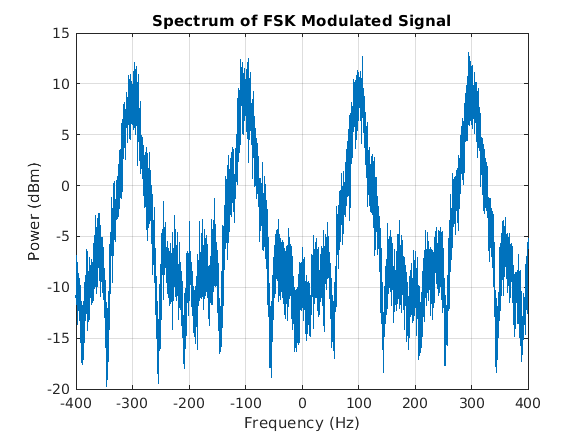

In [25]:
% Generate random data symbols and apply FSK modulation.
%% figures
data = randi([0 3],2000,1);
modSig = fskMod(data);
% spectrum = dsp.SpectrumAnalyzer('SampleRate',fsamp);
% data spectrum before passing through channel
% spectrum(modSig);
% Compute the power spectral density
[pxx, f] = pwelch(modSig, [], [], [], fsamp, 'centered');

% Plot the spectrum data
figure;
plot(f, 10*log10(pxx)+30);
xlabel('Frequency (Hz)');
ylabel('Power (dBm)');
xlim([-400, 400]);
xticks(-400:100:400);
title('Spectrum of FSK Modulated Signal');
grid on;

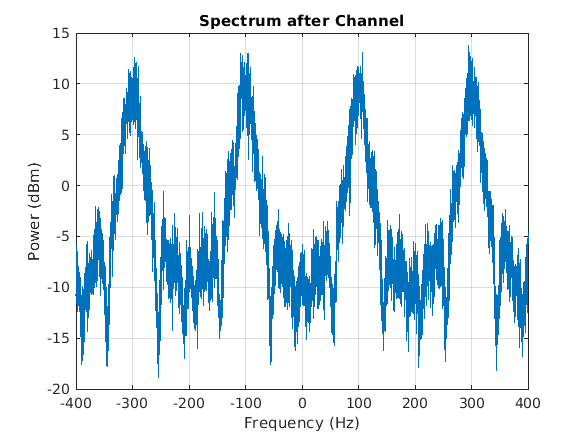

In [26]:
snrdB = 25;
rxSig = awgn(channel(modSig),snrdB);
% spectrum = dsp.SpectrumAnalyzer('SampleRate',fsamp);
% spectrum(rxSig) % data spectrum after passing through channel

% Compute the power spectral density of the received signal
[pxx_rx, f_rx] = pwelch(rxSig, [], [], [], fsamp, 'centered');

% Plot the spectrum data
figure;
plot(f_rx, 10*log10(pxx_rx)+30);
xlabel('Frequency (Hz)');
ylabel('Power (dBm)');
xlim([-400, 400]);
xticks(-400:100:400);
title('Spectrum after Channel');
grid on;


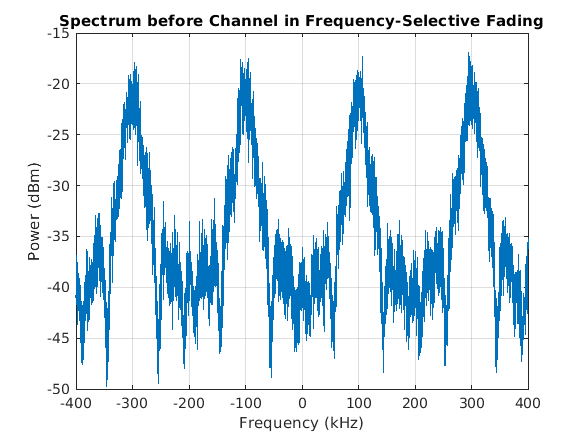

In [27]:
%% FSK Modulation in Frequency-Selective Fading
symbolRate = 45e3;
freqSep = 200e3;
sampPerSym = ceil(M*freqSep/symbolRate);
fsamp = sampPerSym*symbolRate;
release(fskMod)
fskMod.SymbolRate = symbolRate;
fskMod.FrequencySeparation = freqSep;
release(spectrum)
spectrum.SampleRate = sampPerSym*symbolRate;
modSig = fskMod(data);
%spectrum(modSig)
% Compute the power spectral density using pwelch
[pxx, f] = pwelch(modSig, [], [], [], fsamp, 'centered');

% Convert power to dBm
pxx_dBm = 10*log10(pxx) + 30;

% Plot the spectrum data before passing through channel
figure;
plot(f/1000, pxx_dBm);
xlabel('Frequency (kHz)');
ylabel('Power (dBm)');
xlim([-400, 400]);
xticks(-400:100:400);
title('Spectrum before Channel in Frequency-Selective Fading');
grid on;




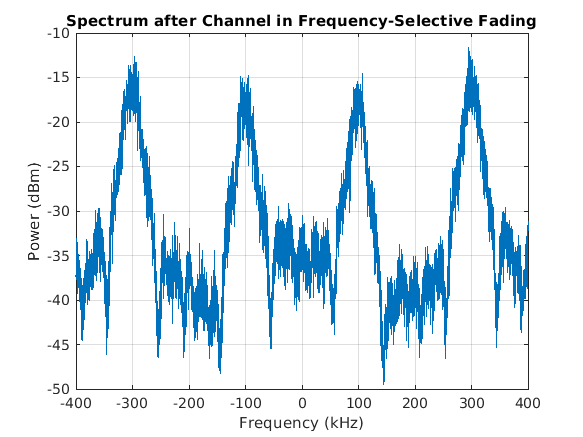

In [28]:
release(channel)
channel.SampleRate = fsamp;
rxSig = awgn(channel(modSig),25);
% spectrum(rxSig) % There are still four identifiable tones but their relative peak power 
% levels differ due to the frequency-selective fading. The signal bandwidth, 800 
% kHz, is larger than the coherence bandwidth, 50 kHz.

% Compute the power spectral density of the received signal using pwelch
[pxx_rx, f_rx] = pwelch(rxSig, [], [], [], fsamp, 'centered');

% Convert received power to dBm
pxx_rx_dBm = 10*log10(pxx_rx) + 30;

% Plot the spectrum data after passing through channel
figure;
plot(f_rx/1000, pxx_rx_dBm);
xlabel('Frequency (kHz)');
ylabel('Power (dBm)');
xlim([-400, 400]);
xticks(-400:100:400);
title('Spectrum after Channel in Frequency-Selective Fading');
grid on;

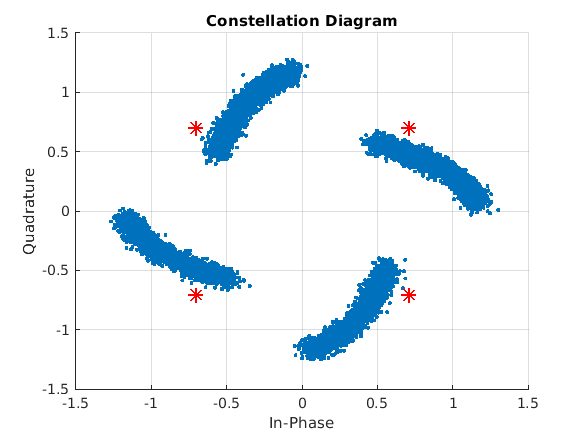

In [29]:
%% QPSK Modulation in Flat Fading


symbolRate = 500;
data = randi([0 3],10000,1);
modSig = pskmod(data,4,pi/4,'gray');
pathDelays = [0 3 10]*1e-6;     % Discrete delays of three-path channel (s)
avgPathGains = [0 -3 -6];       % Average path gains (dB)
fsamp = symbolRate;
channel = comm.RayleighChannel(...
    'SampleRate',fsamp, ...
    'PathDelays',pathDelays, ...
    'AveragePathGains',avgPathGains, ...
    'MaximumDopplerShift',0.01);%, ...
    % 'Visualization','Impulse and frequency responses');
rxSig = awgn(channel(modSig),25);
% Plot the constellation diagram using scatter plot
figure;
% Reference points
ref_points = pskmod(0:3, 4, pi/4, 'gray');

% Constellation diagram
scatter(real(rxSig), imag(rxSig), '.');
hold on;
scatter(real(ref_points), imag(ref_points), 'r*', 'LineWidth', 1.5, 'SizeData', 100);
hold off;
xlabel('In-Phase');
ylabel('Quadrature');
title('Constellation Diagram in flat fading');
grid on;


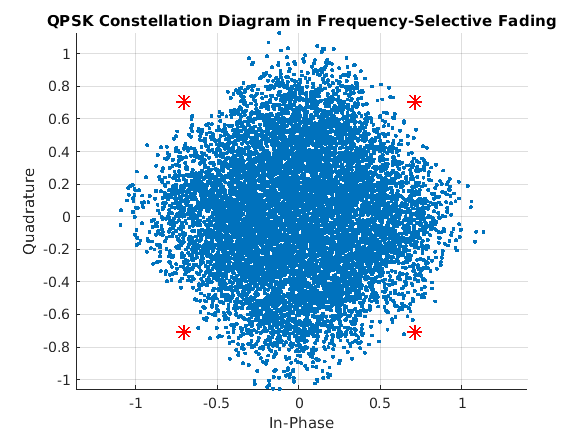

In [30]:
%% QPSK Modulation in Frequency-Selective Fading
symbolRate = 500e3;
release(channel)
channel.SampleRate = symbolRate;
rxSig = awgn(channel(modSig),25);
% constDiagram(rxSig)

% Plot the constellation diagram using scatter plot
figure;

% Reference points
ref_points = pskmod(0:3, 4, pi/4, 'gray');

% Constellation diagram
scatter(real(rxSig), imag(rxSig), '.');
hold on;
scatter(real(ref_points), imag(ref_points), 'r*', 'LineWidth', 1.5, 'SizeData', 100);
hold off;
xlabel('In-Phase');
ylabel('Quadrature');
title('QPSK Constellation Diagram in Frequency-Selective Fading');
grid on;
axis equal;

% As the signal bandwidth is increased from 500 Hz to 500 kHz, the signal 
% becomes highly distorted. This distortion is due to the intersymbol interference 
% (ISI) that comes from time dispersion of the wideband signal. The delay span 
% of the channel (10 microseconds) is now larger than the QPSK symbol period (2 
% microseconds) so the resultant bandlimited impulse response is no longer flat. 
% Alternatively, the signal bandwidth is much larger than the coherence bandwidth, 
% 50 kHz.


As in jupyter notebook, the Channel Visualization tool and Spectrum Analyzer cannot be visualized normally, alternative functions are used here.

For normal MATLAB GUI, these functions should work properly and have better visualization in my current realization even though I use the same Welch method for power density estimation via `pwelch` function.

### WLAN Channel Models

In [1]:
%% WLAN Channel Models
% This example demonstrates passing WLAN S1G, VHT, HT, and non-HT format
% waveforms through appropriate fading channel models. When simulating a
% WLAN communications link, viable options for channel modeling include the
% TGah,TGn and TGac models from WLAN Toolbox&trade; and the additive white
% Gaussian noise (AWGN) and 802.11g models from Communications
% Toolbox&trade;. In this example, it is sufficient to set the channel
% model sampling frequency to match the channel bandwidth because no
% front-end filtering is applied to the signal and the oversampling rate is
% 1.
% 
% In each section of this example, you: 
% 
% * Create a waveform.
% * Transmit it through a fading channel with noise added. 
% * Use a spectrum analyzer to display the waveform before and after it passes 
% through the noisy fading channel. 
%% Pass S1G Waveform Through TGah SISO Channel
% Create a bit stream to use when generating the WLAN S1G format waveform.

bits = randi([0 1],1000,1);
%% 
% Create an S1G configuration object, and then generate a 2 MHz S1G waveform. 
% Calculate the signal power.
%%
s1g = wlanS1GConfig;
preChS1G = wlanWaveformGenerator(bits,s1g);

In [2]:
%% 
% Pass the signal through a TGah SISO channel with AWGN noise (SNR=10 dB)
% and a receiver with a 9 dB noise figure. Recall that the channel model
% sampling frequency is equal to the bandwidth in this example. Set
% property values by using name-value pairs.
% 
% Create a TGah channel object. Set the channel model sampling frequency 
% and channel bandwidth, enable path loss and shadowing, and use the Model-D delay 
% profile.
%%
cbw = s1g.ChannelBandwidth;
fs = 2e6; % Channel model sampling frequency equals the channel bandwidth
tgahChan = wlanTGahChannel('SampleRate',fs,'ChannelBandwidth',cbw, ...
    'LargeScaleFadingEffect','Pathloss and shadowing', ...
    'DelayProfile','Model-D');
%% 
% Create an |<docid:comm_ref.fp292537 AWGNChannel>| object with SNR = 10 
% dB. Determine the signal power in Watts, accounting for the TGah large scale 
% fading pathloss.
%%
preChSigPwr_dB = 20*log10(mean(abs(preChS1G)));
sigPwr = 10^((preChSigPwr_dB-tgahChan.info.Pathloss)/10);

chNoise = comm.AWGNChannel('NoiseMethod','Signal to noise ratio (SNR)',...
    'SNR',10,'SignalPower', sigPwr);

In [3]:
%% 
% Pass the S1G waveform through a SISO TGah channel and add the AWGN channel 
% noise.
%%
postChS1G = chNoise(tgahChan(preChS1G));

In [4]:
%% 
% Create another AWGNChannel object to add receiver 
% noise.
%%
rxNoise = comm.AWGNChannel('NoiseMethod','Variance', ...
    'VarianceSource','Input port');

In [5]:
%% 
% Pass the S1G waveform through the receiver. Choose an appropriate noise 
% variance, nVar, to set the receiver noise level. Here, the receiver noise level 
% is based on the noise variance for a receiver with a 9 dB noise figure. |nVar| 
% = _kTBF_, where _k_ is Boltzmann's constant, _T_ is the ambient temperature 
% of 290 K, _B_ is the bandwidth, and _F_ is the receiver noise figure.
%%
nVar = 10^((-228.6 + 10*log10(290) + 10*log10(fs) + 9)/10);

rxS1G = rxNoise(postChS1G,nVar);

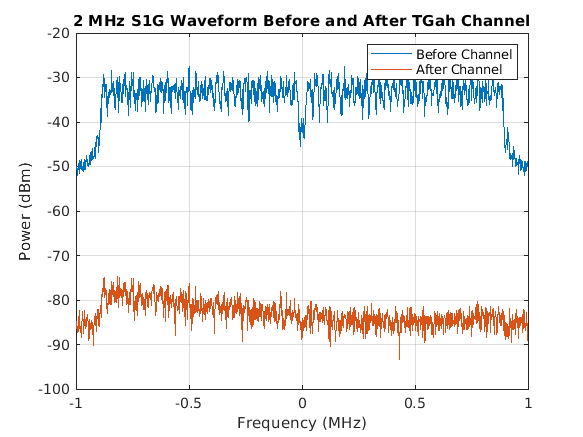

In [6]:
%% 
% Display a spectrum analyzer with before-channel and after-channel waveforms. 
% Use |SpectralAverages| = 10 to reduce noise in the plotted signals.
%%
% title = '2 MHz S1G Waveform Before and After TGah Channel';
% saScope = dsp.SpectrumAnalyzer('SampleRate',fs,'ShowLegend',true,...
%     'AveragingMethod','Exponential','ForgettingFactor',0.99,'Title',title,...
%     'ChannelNames',{'Before','After'});
% saScope([preChS1G,rxS1G])
% Calculate power spectrum using pwelch

[preChPxx, f] = pwelch(preChS1G, [], [], [], fs, 'centered');
[postChPxx, ~] = pwelch(rxS1G, [], [], [], fs, 'centered');

df = fs / length(preChPxx);  % Frequency resolution

% Convert the PSD (preChPxx and postChPxx) to the power spectrum
preChPowerSpectrum = preChPxx * df;
postChPowerSpectrum = postChPxx * df;

% Plot the power spectrum
figure;
plot(f/1e6, 10*log10(preChPowerSpectrum), f/1e6, 10*log10(postChPowerSpectrum));
xlabel('Frequency (MHz)');
ylabel('Power (dBm)');
title('2 MHz S1G Waveform Before and After TGah Channel');
legend('Before Channel', 'After Channel');
grid on;


In [7]:
%% 
% Create a VHT configuration object, and generate an 80 MHz VHT waveform. 
% Calculate the signal power.
%%
vht = wlanVHTConfig;
preChVHT = wlanWaveformGenerator(bits,vht);

In [8]:
%% 
% Pass the signal through a TGac SISO channel with AWGN noise (SNR=10 dB) 
% and a receiver with a 9 dB noise figure. Recall that the channel model sampling 
% frequency is equal to the bandwidth in this example. Set parameters using |Name,Value| 
% pairs.
% 
% Create a TGac channel object. Set the channel model sampling frequency 
% and channel bandwidth, enable path loss and shadowing, and use the Model-D delay 
% profile.
%%
cbw = vht.ChannelBandwidth;
fs = 80e6; % Channel model sampling frequency equals the channel bandwidth
tgacChan = wlanTGacChannel('SampleRate',fs,'ChannelBandwidth',cbw, ...
    'LargeScaleFadingEffect','Pathloss and shadowing', ...
    'DelayProfile','Model-D');

In [9]:
%% 
% Create an AWGNChannel object with SNR = 10 
% dB. Determine the signal power in Watts, accounting for the TGac large scale 
% fading pathloss.
%%
preChSigPwr_dB = 20*log10(mean(abs(preChVHT)));
sigPwr = 10^((preChSigPwr_dB-tgacChan.info.Pathloss)/10);

chNoise = comm.AWGNChannel('NoiseMethod','Signal to noise ratio (SNR)',...
    'SNR',10,'SignalPower', sigPwr);

In [10]:
%% 
% Pass the VHT waveform through a SISO TGac channel and add the AWGN channel 
% noise.
%%
postChVHT = chNoise(tgacChan(preChVHT));

In [11]:
%% 
% Create another AWGNChannel object to add receiver 
% noise.
%%
rxNoise = comm.AWGNChannel('NoiseMethod','Variance', ...
    'VarianceSource','Input port');

In [12]:
%% 
% Pass the VHT waveform through the receiver. Choose an appropriate noise 
% variance, nVar, to set the receiver noise level. Here, the receiver noise level 
% is based on the noise variance for a receiver with a 9 dB noise figure. |nVar| 
% = _kTBF_, where _k_ is Boltzmann's constant, _T_ is the ambient temperature 
% of 290 K, _B_ is the bandwidth, and _F_ is the receiver noise figure.
%%
nVar = 10^((-228.6 + 10*log10(290) + 10*log10(fs) + 9)/10);

rxVHT = rxNoise(postChVHT,nVar);

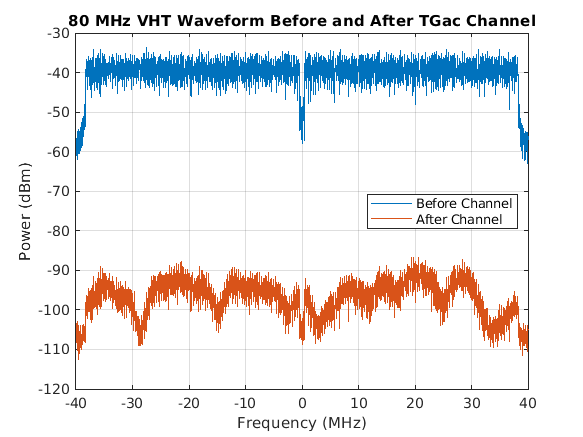

In [13]:
%% 
% Display a spectrum analyzer with before-channel and after-channel waveforms. 
% Use |SpectralAverages| = 10 to reduce noise in the plotted signals.
%%
% title = '80 MHz VHT Waveform Before and After TGac Channel';
% saScope = dsp.SpectrumAnalyzer('SampleRate',fs,'ShowLegend',true,...
%     'AveragingMethod','Exponential','ForgettingFactor',0.99,'Title',title,...
%     'ChannelNames',{'Before','After'});
% saScope([preChVHT,rxVHT])
% Calculate power spectrum using pwelch
[preChPxxVHT, fVHT] = pwelch(preChVHT, [], [], [], fs, 'centered');
[postChPxxVHT, ~] = pwelch(rxVHT, [], [], [], fs, 'centered');

dfVHT = fs / length(preChPxxVHT);  % Frequency resolution

% Convert the PSD (preChPxxVHT and postChPxxVHT) to the power spectrum
preChPowerSpectrumVHT = preChPxxVHT * dfVHT;
postChPowerSpectrumVHT = postChPxxVHT * dfVHT;

% Plot the power spectrum
figure;
plot(fVHT/1e6, 10*log10(preChPowerSpectrumVHT), fVHT/1e6, 10*log10(postChPowerSpectrumVHT));
xlabel('Frequency (MHz)');
ylabel('Power (dBm)');
plotTitleVHT = '80 MHz VHT Waveform Before and After TGac Channel';
title(plotTitleVHT);
legend('Before Channel', 'After Channel','Location','east');
grid on;


In [14]:
%% 
% Path loss accounts for the roughly 50 to 60 dB of separation between the 
% waveform before and after it passes through the TGac channel. The path loss 
% results from the default transmitter-to-receiver distance of 3 meters, and from 
% shadowing effects. The signal level variation shows the frequency selectivity 
% of the delay profile across the frequency spectrum.
%% Pass HT Waveform Through TGn SISO Channel
% Create a bit stream to use when generating the WLAN HT format waveform.
%%
bits = randi([0 1],1000,1);

In [15]:
%% 
% Create an HT configuration object, and generate an HT waveform.
%%
ht = wlanHTConfig;
preChHT = wlanWaveformGenerator(bits,ht);

In [16]:
%% 
% Pass the signal through a TGn SISO channel with AWGN noise (SNR=10 dB) 
% and a receiver with a 9 dB noise figure. Recall that the channel model sampling 
% frequency is equal to the bandwidth in this example. Set parameters using |Name,Value| 
% pairs.
% 
% Create a TGn channel object. Set the channel model sampling frequency and 
% channel bandwidth, enable path loss and shadowing, and use the Model-F delay 
% profile.
%%
fs = 20e6; % Channel model sampling frequency equals the channel bandwidth
tgnChan = wlanTGnChannel('SampleRate',fs,'LargeScaleFadingEffect', ...
    'Pathloss and shadowing','DelayProfile','Model-F');
%% 

In [17]:
%% 
% Pass the HT waveform through a TGn channel. Use the |<docid:comm_ref.fp1221678 
% awgn>| function to add channel noise at an SNR level of 10 dB.
%%
postChHT = awgn(tgnChan(preChHT),10,'measured');

In [18]:
%% 
% Create an |<docid:comm_ref.fp292537 AWGNChannel>| object to add receiver 
% noise.
%%
rxNoise = comm.AWGNChannel('NoiseMethod','Variance', ...
    'VarianceSource','Input port');

In [19]:
%% 
% Pass the HT waveform through the receiver. Choose an appropriate noise 
% variance, nVar, for setting the receiver noise level. Here, the receiver noise 
% is based on the noise variance for a receiver with a 9 dB noise figure. |nVar| 
% = _kTBF_, where _k_ is Boltzmann's constant, _T_ is the ambient temperature 
% of 290 K, _B_ is the bandwidth, and _F_ is the receiver noise figure.
%%
nVar = 10^((-228.6 + 10*log10(290) + 10*log10(fs) + 9)/10);

rxHT = rxNoise(postChHT, nVar);

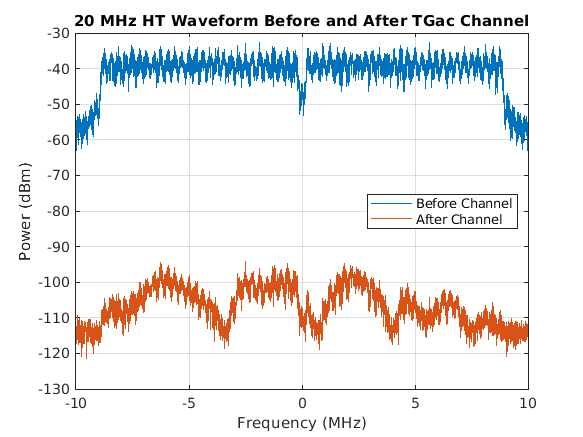

In [20]:
%% 
% Display a spectrum analyzer with before-channel and after-channel waveforms. 
% Use |SpectralAverages| = 10 to reduce noise in the plotted signals.
%%
% title = '20 MHz HT Waveform Before and After TGn Channel';
% saScope = dsp.SpectrumAnalyzer('SampleRate',fs,'ShowLegend',true,...
%     'AveragingMethod','Exponential','ForgettingFactor',0.99,'Title',title,...
%     'ChannelNames',{'Before','After'});
% saScope([preChHT,postChHT])
% Calculate power spectrum using pwelch
[preChPxxnHT, fnHT] = pwelch(preChHT, [], [], [], fs, 'centered');
[postChPxxHT, ~] = pwelch(rxHT, [], [], [], fs, 'centered');

dfnHT = fs / length(preChPxxnHT);  % Frequency resolution

% Convert the PSD (preChPxxnHT and postChPxxHT) to the power spectrum
preChPowerSpectrumHT = preChPxxnHT * dfnHT;
postChPowerSpectrumHT = postChPxxHT * dfnHT;

% Plot the power spectrum
figure;
plot(fnHT/1e6, 10*log10(preChPowerSpectrumHT), fnHT/1e6, 10*log10(postChPowerSpectrumHT));
xlabel('Frequency (MHz)');
ylabel('Power (dBm)');
plotTitleHT = '20 MHz HT Waveform Before and After TGac Channel';
title(plotTitleHT);
legend('Before Channel', 'After Channel','Location','east');
grid on;

In [21]:
%% 
% Path loss accounts for the roughly 50 to 60 dB of separation between the 
% waveform before and after it passes through the TGn channel. The path loss results 
% from the default transmitter-to-receiver distance of 3 meters, and from shadowing 
% effects. The signal level variation shows the frequency selectivity of the delay 
% profile across the frequency spectrum.
%% Pass Non-HT Waveform Through 802.11g Channel
% Create a bit stream to use when generating the WLAN Non-HT format waveform.
%%
bits = randi([0 1],1000,1);
%% 
% Create a non-HT configuration object, and generate a non-HT waveform.
%%
nht = wlanNonHTConfig;
preChNonHT = wlanWaveformGenerator(bits,nht);

In [22]:
%% 
% Calculate free-space path loss for a transmitter-to-receiver separation 
% distance of 3 meters. Create an 802.11g channel object with a 3 Hz maximum Doppler 
% shift and an RMS path delay equal to two times the sample time. Recall that 
% the channel model sampling frequency is equal to the bandwidth in this example. 
% Create an AWGN channel object.
%%
dist = 3;
fc = 2.4e9;
pathLoss = 10^(-log10(4*pi*dist*(fc/3e8)));
fs = 20e6; % Channel model sampling frequency equals the channel bandwidth
maxDoppShift = 3;
trms = 2/fs;
ch802 = comm.RayleighChannel('SampleRate',fs,'MaximumDopplerShift',maxDoppShift,'PathDelays',trms);

In [23]:
%% 
% Pass the non-HT waveform through an 802.11g channel. Use the |<docid:comm_ref.fp1221678 
% awgn>| function to add channel noise at an SNR level of 10 dB.
%%
postChNonHT = awgn(ch802(preChNonHT),10,'measured');

In [24]:
%% 
% Create an |<docid:comm_ref.fp292537 AWGNChannel>| object to add receiver 
% noise.
%%
rxNoise = comm.AWGNChannel('NoiseMethod','Variance', ...
    'VarianceSource','Input port');

In [25]:
%% 
% Pass the non-HT waveform through the receiver. Choose an appropriate noise 
% variance, |nVar|, for setting the receiver noise level. Here, the receiver noise 
% is based on the noise variance for a receiver with a 9 dB noise figure. |nVar| 
% = _kTBF_, where _k_ is Boltzmann's constant, _T_ is the ambient temperature 
% of 290 K, _B_ is the bandwidth, and _F_ is the receiver noise figure.
%%
nVar = 10^((-228.6 + 10*log10(290) + 10*log10(fs) + 9)/10);

rxNonHT = rxNoise(postChNonHT, nVar)* pathLoss;

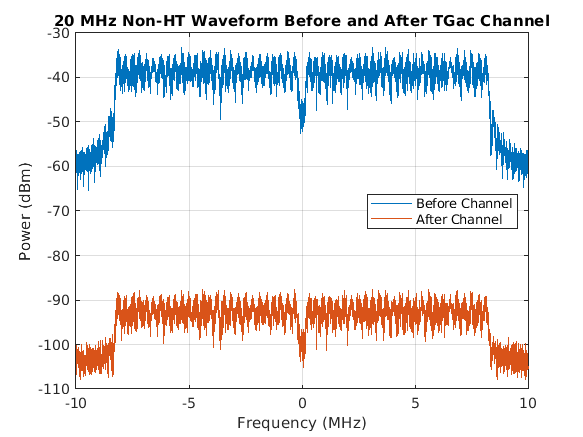

In [26]:
%% 
% Display a spectrum analyzer with before-channel and after-channel waveforms. 
% Use |SpectralAverages| = 10 to reduce noise in the plotted signals.
%%
% title = '20 MHz Non-HT Waveform Before and After 802.11g Channel';
% saScope = dsp.SpectrumAnalyzer('SampleRate',fs,'ShowLegend',true,...
%     'AveragingMethod','Exponential','ForgettingFactor',0.99,'Title',title,...
%     'ChannelNames',{'Before','After'});
% saScope([preChNonHT,rxNonHT])
% Calculate power spectrum using pwelch
[preChPxxnHT, fnHT] = pwelch(preChNonHT, [], [], [], fs, 'centered');
[postChPxxnHT, ~] = pwelch(rxNonHT, [], [], [], fs, 'centered');

dfnHT = fs / length(preChPxxnHT);  % Frequency resolution

% Convert the PSD (preChPxxnHT and postChPxxHT) to the power spectrum
preChPowerSpectrumnHT = preChPxxnHT * dfnHT;
postChPowerSpectrumnHT = postChPxxnHT * dfnHT;

% Plot the power spectrum
figure;
plot(fnHT/1e6, 10*log10(preChPowerSpectrumnHT), fnHT/1e6, 10*log10(postChPowerSpectrumnHT));
xlabel('Frequency (MHz)');
ylabel('Power (dBm)');
plotTitlenHT = '20 MHz Non-HT Waveform Before and After TGac Channel';
title(plotTitlenHT);
legend('Before Channel', 'After Channel','Location','east');
grid on;

In [27]:
%% 
% Free-space path loss accounts for the roughly 50 to 60 dB of separation 
% between the waveform before and after it passes through the 802.11g channel. 
% The path loss results from the specified transmitter-to-receiver distance of 
% 3 meters, and from shadowing effects. The signal level variation shows the frequency 
% selectivity of the delay profile across the frequency spectrum.
%% Pass VHT Waveform Through TGac MIMO Channel
% Create a bit stream to use when generating the WLAN VHT format waveform.
%%
bits = randi([0 1],1000,1);


In [28]:
%% 
% Create a multi-user VHT configuration object, and generate a VHT waveform. 
% Set the number of transmit antennas to four. Set the number of space-time streams 
% and the number of receive antennas to 3. Because the number of transmit antennas 
% is not equal to the number of space-time streams, the spatial mapping is not 
% direct. Set the spatial mapping to Hadamard.
%%
ntx = 4;
nsts = 3;
nrx = 3;
vht = wlanVHTConfig('NumTransmitAntennas',ntx, ...
    'NumSpaceTimeStreams',nsts,'SpatialMapping','Hadamard');
preChVHT = wlanWaveformGenerator(bits,vht);

In [29]:
%% 
% Create TGac MIMO channel and AWGN channel objects. Recall that the channel 
% model sampling frequency is equal to the bandwidth in this example. Disable 
% large-scale fading effects.
%%
cbw = vht.ChannelBandwidth;
fs = 80e6; % Channel model sampling frequency equals the channel bandwidth
tgacChan = wlanTGacChannel('SampleRate',fs,'ChannelBandwidth',cbw,...
    'NumTransmitAntennas',ntx,'NumReceiveAntennas',nrx);
tgacChan.LargeScaleFadingEffect = 'None';

In [30]:
%% 
% Pass the VHT waveform through a TGac channel. Use the |<docid:comm_ref.fp1221678 
% awgn>| function to add channel noise at an SNR level of 10 dB.
%%
postChVHT = awgn(tgacChan(preChVHT),10,'measured');

In [31]:
%% 
% Create an |<docid:comm_ref.fp292537 AWGNChannel>| object to add receiver 
% noise.
%%
rxNoise = comm.AWGNChannel('NoiseMethod','Variance', ...
    'VarianceSource','Input port');

In [32]:
%% 
% Pass the multi-user VHT waveform through a noisy TGac channel. Choose 
% an appropriate noise variance, nVar, for setting the AWGN level. Here, the AWGN 
% level is based on the noise variance for a receiver with a 9 dB noise figure. 
% |nVar| = _kTBF_, where _k_ is Boltzmann's constant, _T_ is the ambient temperature 
% of 290 K, _B_ is the bandwidth, and _F_ is the receiver noise figure.
%%
nVar = 10^((-228.6 + 10*log10(290) + 10*log10(fs) + 9)/10);

rxVHT = rxNoise(postChVHT,nVar);

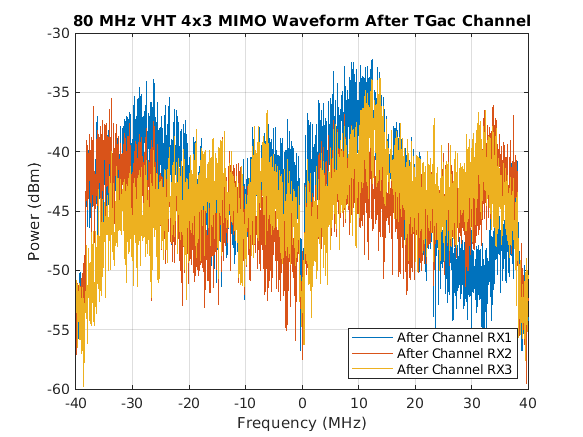

In [33]:
%% 
% Display a spectrum analyzer showing the multiple streams after the channel 
% effects have been added. Use |SpectralAverages| = 10 to reduce noise in the 
% plotted signals.
%%
% title = '80 MHz VHT 4x3 MIMO Waveform After TGac Channel';
% saScope = dsp.SpectrumAnalyzer('SampleRate',fs,'ShowLegend',true,...
%     'AveragingMethod','Exponential','ForgettingFactor',0.99,'Title',title,...
%     'ChannelNames',{'RX1','RX2','RX3'});
% saScope(rxVHT)

% Separate the received signals into individual streams
rxVHT1 = rxVHT(:, 1);
rxVHT2 = rxVHT(:, 2);
rxVHT3 = rxVHT(:, 3);

% Calculate power spectrum using pwelch
[preChPxxVHT, fVHT] = pwelch(preChVHT, [], [], [], fs, 'centered');
[postChPxxVHT1, ~] = pwelch(rxVHT1, [], [], [], fs, 'centered');
[postChPxxVHT2, ~] = pwelch(rxVHT2, [], [], [], fs, 'centered');
[postChPxxVHT3, ~] = pwelch(rxVHT3, [], [], [], fs, 'centered');

dfVHT = fs / length(preChPxxVHT);  % Frequency resolution

% Convert the PSD (preChPxxVHT and postChPxxVHT) to the power spectrum
preChPowerSpectrumVHT = preChPxxVHT * dfVHT;
postChPowerSpectrumVHT1 = postChPxxVHT1 * dfVHT;
postChPowerSpectrumVHT2 = postChPxxVHT2 * dfVHT;
postChPowerSpectrumVHT3 = postChPxxVHT3 * dfVHT;

% Plot the power spectrum
figure;
plot(fVHT/1e6, 10*log10(postChPowerSpectrumVHT1), ...
     fVHT/1e6, 10*log10(postChPowerSpectrumVHT2), ...
     fVHT/1e6, 10*log10(postChPowerSpectrumVHT3));
xlabel('Frequency (MHz)');
ylabel('Power (dBm)');
plotTitleVHT = '80 MHz VHT 4x3 MIMO Waveform After TGac Channel';
title(plotTitleVHT);
legend('After Channel RX1', 'After Channel RX2', 'After Channel RX3', 'Location', 'southeast');
grid on;

%% 
% The overlaid signals show the TGac channel variation between the received 
% streams.

### QPSK Transmitter and Receiver in Simulink

Since this module requires **Simulink**, it is not convenient to visualize the results in the notebook, using screenshot instead.

[Reference](https://ww2.mathworks.cn/help/comm/ug/qpsk-transmitter-and-receiver-in-simulink.html) can be found here.

Result

![Result](results/QPSK.png)

```MATLAB   
Error rate = 0.000948.
Number of detected errors = 1458.
Total number of compared samples = 1538460.

```

### Visualize RF Impairments

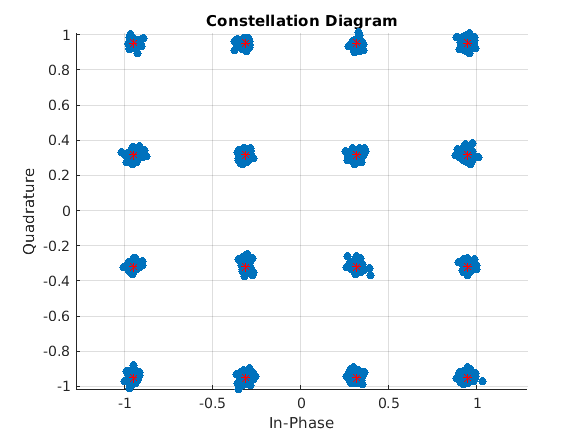

In [105]:
% White noise
fs = 1000;
M = 16;
snrdB = 30;
refConst = qammod(0:M-1,M,'UnitAveragePower',true);
constDiagram = comm.ConstellationDiagram('ReferenceConstellation',refConst);

timeScope = timescope('YLimits',[   0 40],'SampleRate',fs,'TimeSpanSource','property','TimeSpan',1, ...
    'ShowGrid',true,'YLabel','EVM (%)');

data = randi([0 M-1],1000,1);
modSig = qammod(data,M,'UnitAveragePower',true);
noisySig = awgn(modSig,snrdB);

% constDiagram(noisySig);
figure;
scatter(real(noisySig), imag(noisySig), 'filled');
hold on;
scatter(real(refConst), imag(refConst), 'r*');
grid on;
xlabel('In-Phase');
ylabel('Quadrature');
title('Constellation Diagram');
axis equal;

% imshow(frame);


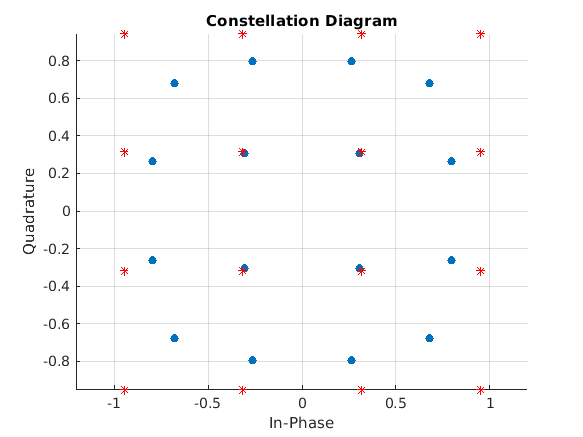

In [106]:
evm = comm.EVM('ReferenceSignalSource','Estimated from reference constellation', ...
    'ReferenceConstellation',refConst, ...
    'Normalization','Average constellation power');

rmsEVM = evm(noisySig);

mer = comm.MER('ReferenceSignalSource','Estimated from reference constellation', ...
    'ReferenceConstellation',refConst);
snrEst = mer(noisySig);

% Amplifier Distortion----------------------------------------------------

amp = comm.MemorylessNonlinearity('IIP3',38,'AMPMConversion',0);
txSig = amp(modSig);

% constDiagram(txSig);
figure;
scatter(real(txSig), imag(txSig), 'filled');
hold on;
scatter(real(refConst), imag(refConst), 'r*');
grid on;
xlabel('In-Phase');
ylabel('Quadrature');
title('Constellation Diagram');
axis equal;

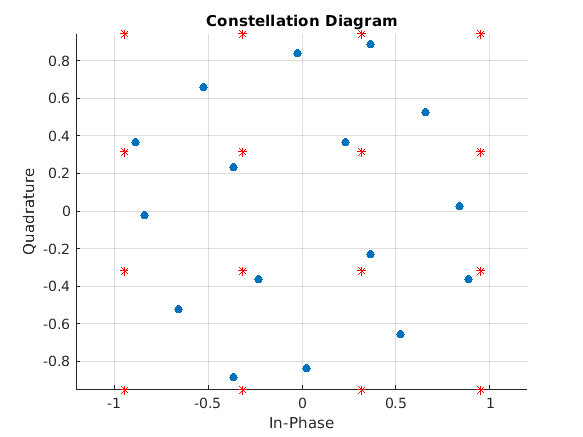

In [107]:
amp.AMPMConversion = 1;
txSig = amp(modSig);
% constDiagram(txSig);
figure;
scatter(real(txSig), imag(txSig), 'filled');
hold on;
scatter(real(refConst), imag(refConst), 'r*');
grid on;
xlabel('In-Phase');
ylabel('Quadrature');
title('Constellation Diagram');
axis equal;

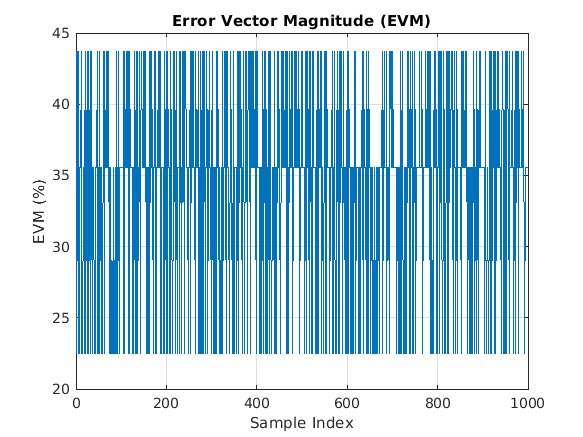

In [110]:
evm = comm.EVM('AveragingDimensions',2);
evmTime = evm(modSig,txSig);

% timeScope(evmTime);
% Visualize EVM in Jupyter Notebook
figure;
plot(evmTime);
xlabel('Sample Index');
ylabel('EVM (%)');
title('Error Vector Magnitude (EVM)');
grid on;

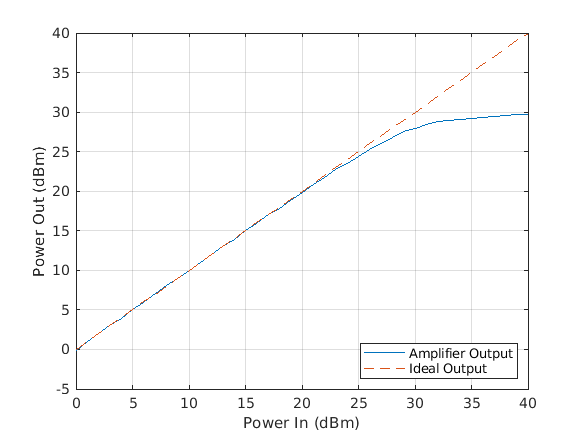

In [111]:
evmRMS = sqrt(mean(evmTime.^2));

mer = comm.MER;
snrEst = mer(modSig,txSig);

powerIn = 0:40;
pin = 10.^((powerIn-30)/10);
powerOut = zeros(length(powerIn),1);

for k = 1:length(powerIn)
    data = randi([0 15],1000,1);
    txSig = qammod(data,16,'UnitAveragePower',true)*sqrt(pin(k));
    ampSig = amp(txSig);
    powerOut(k) = 10*log10(var(ampSig))+30;
end


plot(powerIn,powerOut,powerIn,powerIn,'--')
legend('Amplifier Output','Ideal Output','location','se')
xlabel('Power In (dBm)')
ylabel('Power Out (dBm)')
grid


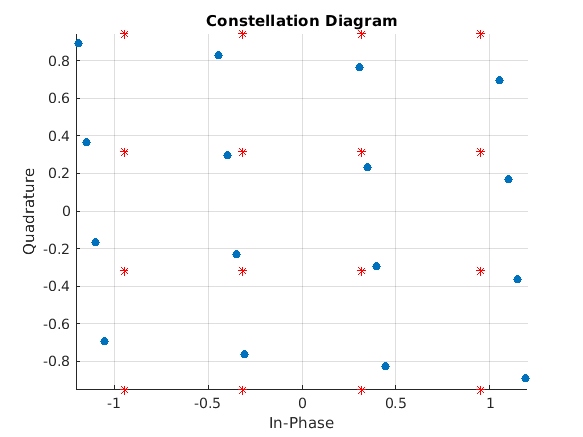

In [112]:
% I/Q Imbalance-----------------------------------------------

ampImb = 3;
phImb = 10;
rxSig = iqimbal(modSig,ampImb,phImb);

% constDiagram(rxSig)
figure;
scatter(real(rxSig), imag(rxSig), 'filled');
hold on;
scatter(real(refConst), imag(refConst), 'r*');
grid on;
xlabel('In-Phase');
ylabel('Quadrature');
title('Constellation Diagram');
axis equal;


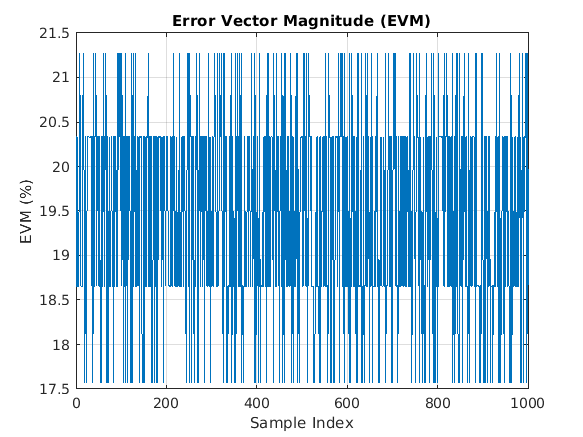

In [113]:

evmTime = evm(modSig,rxSig);

% timeScope(evmTime)
figure;
plot(evmTime);
xlabel('Sample Index');
ylabel('EVM (%)');
title('Error Vector Magnitude (EVM)');
grid on;

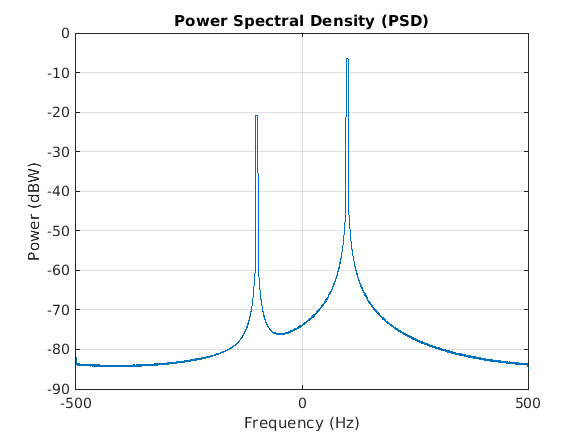

In [117]:
sinewave = dsp.SineWave('Frequency',100,'SampleRate',1000, ...
    'SamplesPerFrame',1e4,'ComplexOutput',true);

x = sinewave();

ampImb = 3;
phImb = 10;
y = iqimbal(x,ampImb,phImb);

% spectrum = dsp.SpectrumAnalyzer('SampleRate',1000,'PowerUnits','dBW');

% spectrum(y)
% Calculate the Power Spectral Density (PSD) using pwelch
[psd, f] = pwelch(y, [], [], [], 1000, 'centered', 'psd');
% Smooth the PSD using a moving average filter
windowSize = 20; % Adjust this value to change the amount of smoothing
smoothed_psd = smooth(psd, windowSize);

% Visualize the smoothed PSD in Jupyter Notebook
figure;
plot(f, 10 * log10(smoothed_psd));
xlabel('Frequency (Hz)');
ylabel('Power (dBW)');
title('Power Spectral Density (PSD)');
grid on;

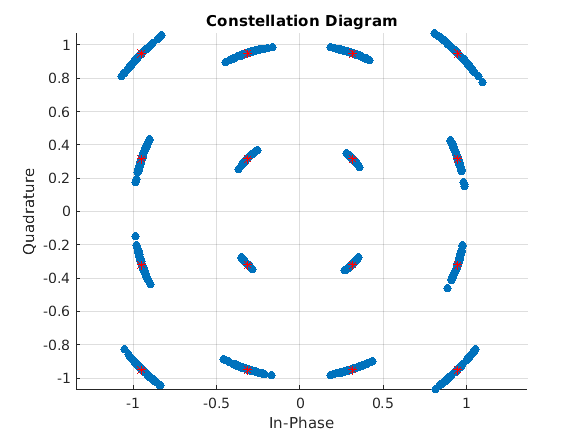

In [118]:
%Phase Noise-------------------------------------------------------------

pnoise = comm.PhaseNoise('Level',-50,'FrequencyOffset',20,'SampleRate',fs);
pnoiseSig = pnoise(modSig);

%constDiagram(pnoiseSig)
figure;
scatter(real(pnoiseSig), imag(pnoiseSig), 'filled');
hold on;
scatter(real(refConst), imag(refConst), 'r*');
grid on;
xlabel('In-Phase');
ylabel('Quadrature');
title('Constellation Diagram');
axis equal;


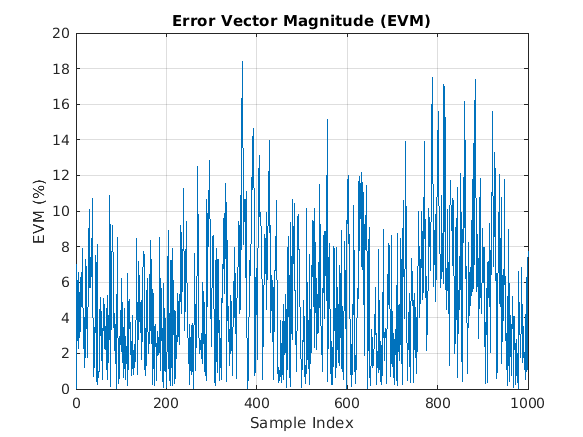

In [119]:
evmTime = evm(modSig,pnoiseSig);

% timeScope(evmTime)
figure;
plot(evmTime);
xlabel('Sample Index');
ylabel('EVM (%)');
title('Error Vector Magnitude (EVM)');
grid on;

evmRMS = sqrt(mean(evmTime.^2));

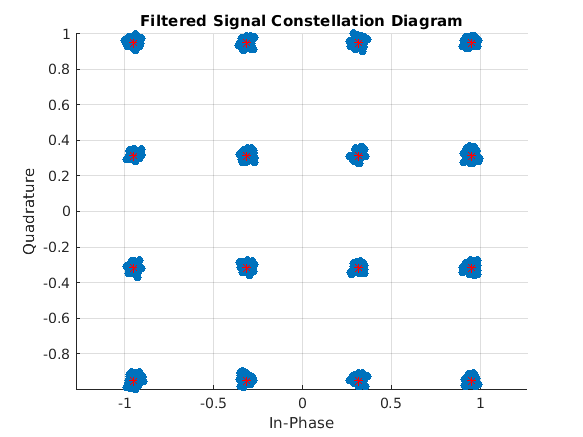

In [120]:
% Filter Effects-----------------------------------------------------------

sps = 4;
txfilter = comm.RaisedCosineTransmitFilter('RolloffFactor',0.2,'FilterSpanInSymbols',8, ...
    'OutputSamplesPerSymbol',sps,'Gain',sqrt(sps));

rxfilter = comm.RaisedCosineReceiveFilter('RolloffFactor',0.2,'FilterSpanInSymbols',8, ...
    'InputSamplesPerSymbol',sps,'Gain',1/sqrt(sps), ...
    'DecimationFactor',sps);

fltDelay = 0.5*(txfilter.FilterSpanInSymbols + rxfilter.FilterSpanInSymbols);

filtSig = txfilter(modSig);
rxSig = rxfilter(filtSig);

rxSig = rxSig(fltDelay+1:end);

% constDiagram = comm.ConstellationDiagram('ReferenceConstellation',refConst);
% Visualize the constellation diagram of the filtered signal
figure;
scatter(real(rxSig), imag(rxSig), 'filled');
hold on;
scatter(real(refConst), imag(refConst), 'r*');
grid on;
xlabel('In-Phase');
ylabel('Quadrature');
title('Filtered Signal Constellation Diagram');
axis equal;


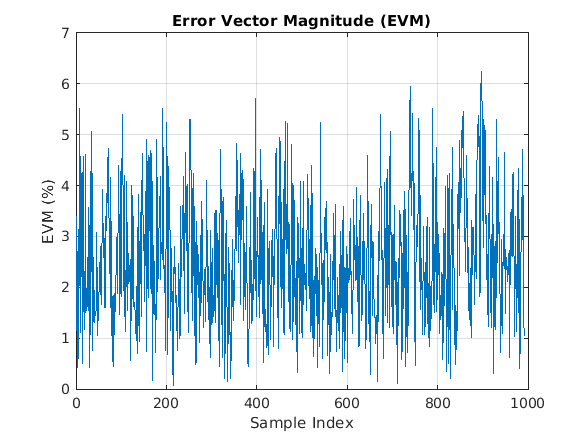

In [121]:
evm = comm.EVM('ReferenceSignalSource','Estimated from reference constellation', ...
    'ReferenceConstellation',refConst, ...
    'Normalization','Average constellation power','AveragingDimensions',2);
evmTime = evm(rxSig);
figure;
plot(evmTime);
xlabel('Sample Index');
ylabel('EVM (%)');
title('Error Vector Magnitude (EVM)');
grid on;
evmRMS = sqrt(mean(evmTime.^2));
mer = comm.MER;
snrEst = mer(modSig(1:end-fltDelay),rxSig);

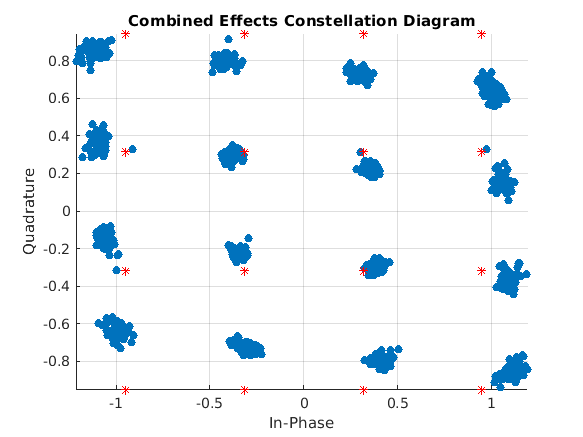

In [122]:
% Combined Effects--------------------------------------------------------

evm = comm.EVM('ReferenceSignalSource','Estimated from reference constellation', ...
    'ReferenceConstellation',refConst, ...
    'Normalization','Average constellation power','AveragingDimensions',2);

% timeScope = timescope('YLimits',[0 40],'SampleRate',fs,'TimeSpanSource','property','TimeSpan',1, ...
%     'ShowGrid',true,'YLabel','EVM (%)');

% constDiagram = comm.ConstellationDiagram('ReferenceConstellation',refConst);

amp = comm.MemorylessNonlinearity('IIP3',45,'AMPMConversion',0);
pnoise = comm.PhaseNoise('Level',-55,'FrequencyOffset',20,'SampleRate',fs);

txfiltOut = txfilter(modSig);
txSig = amp(txfiltOut);

rxSig = awgn(txSig,snrdB);
iqImbalSig = iqimbal(rxSig,ampImb,phImb);
pnoiseSig = pnoise(iqImbalSig);
rxfiltOut = rxfilter(pnoiseSig);
figure;
scatter(real(rxfiltOut), imag(rxfiltOut), 'filled');
hold on;
scatter(real(refConst), imag(refConst), 'r*');
grid on;
xlabel('In-Phase');
ylabel('Quadrature');
title('Combined Effects Constellation Diagram');
axis equal;

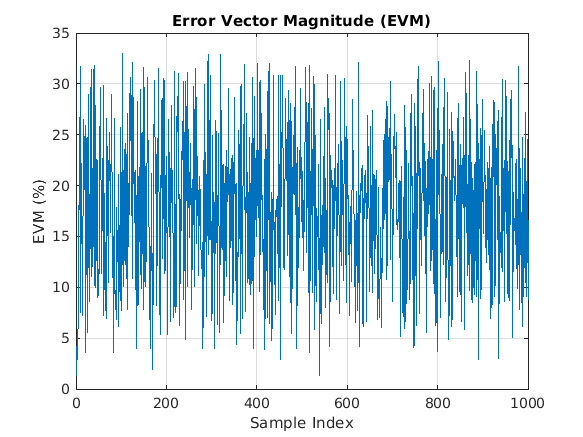

In [123]:
evmTime = evm(rxfiltOut);
% timeScope(evmTime)
figure;
plot(evmTime);
xlabel('Sample Index');
ylabel('EVM (%)');
title('Error Vector Magnitude (EVM)');
grid on;
evmRMS = sqrt(mean(evmTime.^2));

mer = comm.MER('ReferenceSignalSource','Estimated from reference constellation', ...
    'ReferenceConstellation',refConst);
snrEst = mer(rxfiltOut);

### Joint Sampling Clock and Carrier Frequency Offset Tracking

In [125]:
%% https://ww2.mathworks.cn/help/wlan/ug/joint‐sampling‐rate‐and‐carrierfrequency‐offset‐tracking.html
% require MATLAB R2022a or higher
% Generate a Baseband Waveform
cfgVHT = wlanVHTConfig;
cfgVHT.ChannelBandwidth = 'CBW20';
cfgVHT.NumTransmitAntennas = 1;
cfgVHT.NumSpaceTimeStreams = 1;
cfgVHT.MCS = 4;          % 16-QAM and 3/4 coding rate
cfgVHT.APEPLength = 500; % Bytes

% Create a random PSDU
s = rng(10); % Seed the random number generator
psdu = randi([0 1],8*cfgVHT.PSDULength,1,'int8');

% Generate a VHT packet
tx = wlanWaveformGenerator(psdu,cfgVHT);


In [126]:
%% Model Impairments
sco = -100; % Sampling clock offset in PPM
sro = -sco/(1+sco/1e6); % Sample rate offset in PPM
samplingClockoffset = comm.SampleRateOffset(sro);
rx = samplingClockoffset([tx; zeros(100,cfgVHT.NumTransmitAntennas)]);
% Add residual carrier frequency offset to the waveform
fc = 5.25e9;         % Carrier frequency, Hertz
cfo = (sco*1e-6)*fc; % Carrier frequency offset, Hertz
fs = wlanSampleRate(cfgVHT);           % Baseband sample rate
rx = frequencyOffset(rx,fs,cfo); % Add frequency offset
% Add noise to the waveform with 30 dBW variance.

awgnChannel = comm.AWGNChannel('NoiseMethod','Variance','Variance',10^(-30/10));
rx = awgnChannel(rx);


In [127]:
%% Front-End Synchronization and Receiver Processing
% Generate field indices and perform packet detection.

ind = wlanFieldIndices(cfgVHT);
tOff = wlanPacketDetect(rx,cfgVHT.ChannelBandwidth);
% Perform coarse frequency offset correction.
lstf = rx(tOff+(ind.LSTF(1):ind.LSTF(2)),:);
coarseCFOEst = wlanCoarseCFOEstimate(lstf,cfgVHT.ChannelBandwidth);
rx = frequencyOffset(rx,fs,-coarseCFOEst);
% Perform symbol timing synchronization.

nonhtPreamble = rx(tOff+(ind.LSTF(1):ind.LSIG(2)),:);
symOff = wlanSymbolTimingEstimate(nonhtPreamble,cfgVHT.ChannelBandwidth);
tOff = tOff+symOff;

% Perform fine frequency offset correction.
lltf = rx(tOff+(ind.LLTF(1):ind.LLTF(2)),:);
fineCFOEst = wlanFineCFOEstimate(lltf,cfgVHT.ChannelBandwidth);
rx = frequencyOffset(rx,fs,-fineCFOEst);

% Perform channel estimation.

vhtltf = rx(tOff+(ind.VHTLTF(1):ind.VHTLTF(2)),:);
vhtltfDemod = wlanVHTLTFDemodulate(vhtltf,cfgVHT);
[chanEst,chanEstSSPilots] = wlanVHTLTFChannelEstimate(vhtltfDemod,cfgVHT);




In [128]:
%% Recovery Without Sampling Clock Offset or Residual CFO Tracking
disp('Front-end impairment correction:');
% Front-end impairment correction:
frontEndCFOEst = coarseCFOEst+fineCFOEst;
disp(['  Estimated CFO: ' num2str(frontEndCFOEst,'%.1f') ' Hz']);
residualCFO = cfo-frontEndCFOEst;
disp(['  Residual CFO after initial correction: ' num2str(residualCFO,'%.1f') ' Hz']);


Front-end impairment correction:
  Estimated CFO: -525209.0 Hz
  Residual CFO after initial correction: 209.0 Hz


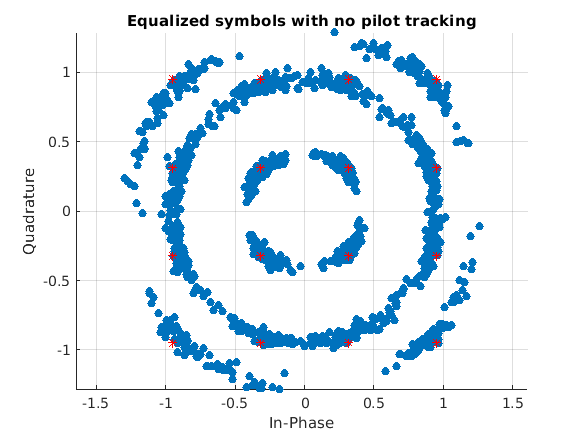

Bit error rate:
  Without tracking: 0.066964


In [132]:
% Create a recovery configuration with pilot tracking disabled.

cfgRec = trackingRecoveryConfig;
cfgRec.PilotTracking = 'None';

% Extract data field with Ne additional samples to allow for negative SCO.

maxDuration = 5.484e-3; % Maximum packet duration in seconds
maxSCO = 120;           % PPM
Ne = ceil(fs*maxDuration*maxSCO*1e-6); % Number of extra samples
dataInd = tOff+(ind.VHTData(1):ind.VHTData(2)+Ne);
dataInd = dataInd(dataInd<=length(rx)); % Only use indices within waveform
data = rx(dataInd,:); 

% Perform demodulation and decoding.
[rxPSDUNoTrack,~,eqSymNoTrack] = trackingVHTDataRecover(data,chanEst,chanEstSSPilots,cfgVHT,cfgRec);

% % Plot the equalized constellation
% ConstNoTrack = comm.ConstellationDiagram;
% ConstNoTrack.Title = 'Equalized symbols with no pilot tracking';
% ConstNoTrack.ReferenceConstellation = wlanReferenceSymbols(cfgVHT);
% ConstNoTrack(eqSymNoTrack(:));
% release(ConstNoTrack)
% Visualize the equalized constellation in Jupyter Notebook
refSymbols = wlanReferenceSymbols(cfgVHT);
figure;
scatter(real(eqSymNoTrack(:)), imag(eqSymNoTrack(:)), 'filled');
hold on;
scatter(real(refSymbols), imag(refSymbols), 'r*');
grid on;
xlabel('In-Phase');
ylabel('Quadrature');
title('Equalized symbols with no pilot tracking');
axis equal;

[~,berNoTrack] = biterr(rxPSDUNoTrack,psdu);
disp('Bit error rate:');
% Bit error rate:
disp(['  Without tracking: ' num2str(berNoTrack)]);


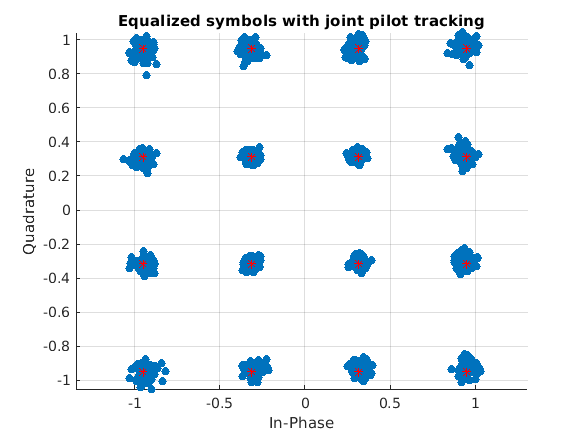

  With tracking: 0


In [133]:
%% Recovery With Sampling Clock Offset Tracking and Residual CFO Tracking

% Create a recovery configuration with pilot tracking enabled.

cfgRec = trackingRecoveryConfig;
cfgRec.PilotTracking = 'Joint'; % Joint timing and phase tracking
cfgRec.PilotTrackingWindow = 9; % Averaging window in OFDM symbols

% Perform demodulation and decoding.

[rxPSDU,~,eqSymTrack,cpe,peg] = trackingVHTDataRecover(data,chanEst,chanEstSSPilots,cfgVHT,cfgRec);

% Plot the equalized constellation. This shows a clear 16-QAM constellation with no spreading or rotation. The decoded PSDU contains no bit errors.

% ConstTrack = comm.ConstellationDiagram;
% ConstTrack.Title = 'Equalized symbols with joint pilot tracking';
% ConstTrack.ReferenceConstellation = wlanReferenceSymbols(cfgVHT);
% ConstTrack(eqSymTrack(:));
% release(ConstTrack)
% Visualize the equalized constellation with joint pilot tracking in Jupyter Notebook
refSymbols = wlanReferenceSymbols(cfgVHT);
figure;
scatter(real(eqSymTrack(:)), imag(eqSymTrack(:)), 'filled');
hold on;
scatter(real(refSymbols), imag(refSymbols), 'r*');
grid on;
xlabel('In-Phase');
ylabel('Quadrature');
title('Equalized symbols with joint pilot tracking');
axis equal;

[~,berTrack] = biterr(rxPSDU,psdu);
disp(['  With tracking: ' num2str(berTrack)]);



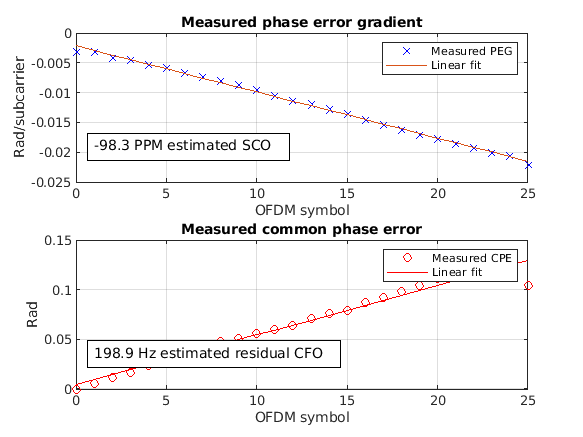

Tracked impairments:
  Estimated residual CFO: 198.9 Hz (-10.1 Hz error)
  Estimated SCO: -98.3 PPM (1.7 PPM error)
Estimated CFO (initial + tracked): -525010.1 Hz (-10.1 Hz error)


In [134]:
[residualCFOEst,scoEst] = trackingPlotSCOCFOEstimates(cpe,peg,cfgVHT);
fprintf('Tracked impairments:\n');
fprintf('  Estimated residual CFO: %3.1f Hz (%.1f Hz error)\n', ...
    residualCFOEst,residualCFOEst-residualCFO);

% Estimated residual CFO: 198.9 Hz (-10.1 Hz error)
fprintf('  Estimated SCO: %3.1f PPM (%.1f PPM error)\n',scoEst,scoEst-sco);
cfoEst = frontEndCFOEst+residualCFOEst; % Initial + tracked CFO estimate
fprintf('Estimated CFO (initial + tracked): %.1f Hz (%.1f Hz error)\n',cfoEst,cfoEst-cfo);

rng(s); % Restore the state of the random number generator


### WLAN PPDU Structure and Examples

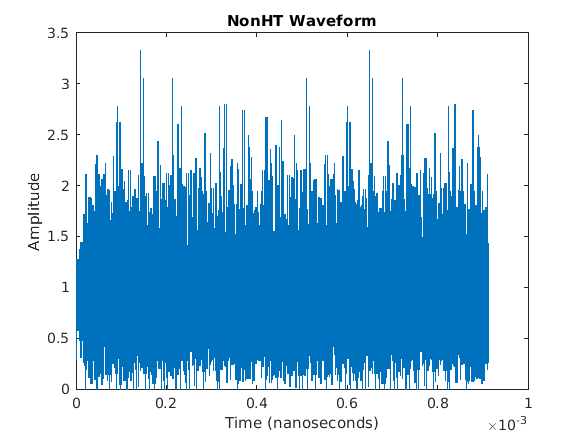

In [62]:
%% Build Non HT PPDU waveform
% Create a non-HT configuration object
cfgNonHT = wlanNonHTConfig('ChannelBandwidth','CBW20','NumTransmitAntennas',1,'MCS',1);
% Generate the non-HT PPDU
bits = [1;0;0;1];
txWaveform = wlanWaveformGenerator(bits,cfgNonHT);
% Plot the magnitude of the waveform.
figure(1);
fsNonHT = wlanSampleRate(cfgNonHT);
time = (0:length(txWaveform)-1)/fsNonHT;
plot(time,abs(txWaveform));
title('NonHT Waveform');
xlabel('Time (nanoseconds)');
ylabel('Amplitude');

In [66]:
%% 802.11be Waveform Generation (WiFi 7)
%% Single-User Packet Generation
cfgSU = wlanEHTMUConfig('CBW320'); % full 320MHz bandwidth
numTx = 2; % Number of transmit antennas
cfgSU.NumTransmitAntennas = numTx;
cfgSU.User{1}.APEPLength = 8000; % A-MPDU length pre-EOF padding, in bytes
cfgSU.User{1}.MCS = 12;          % Modulation and coding scheme
cfgSU.User{1}.NumSpaceTimeStreams = numTx;
% Get the required PSDU length for the specified transmission configuration and create a random PSDU of this length for transmission.
psdu = randi([0 1],psduLength(cfgSU)*8,1,'int8');
% Generate the EHT MU single-user packet by using the wlanWaveformGenerator function.
tx = wlanWaveformGenerator(psdu,cfgSU); %#ok<*NASGU> % Create packet

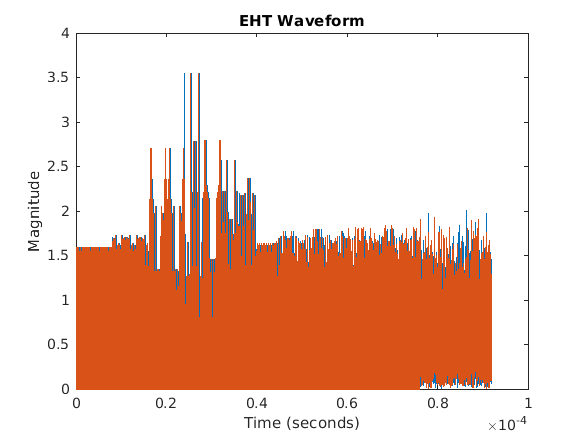

In [67]:
% Plot the EHT waveform
fsEHT = wlanSampleRate(cfgSU);
time = (0:length(tx)-1)/fsEHT;
plot(time,abs(tx));
xlabel ('Time (seconds)')
ylabel('Magnitude')
title('EHT Waveform')

In [34]:
%% MU-MIMO Packet Generation
% Create a 20 MHz (MU-MIMO) EHT MU configuration for two users and set parameters common to all users.
numTx = 2; % Number of transmit antennas
% Set common transmission parameters for all users
cfgMUMIMO = wlanEHTMUConfig('CBW20','NumUsers',2); 
cfgMUMIMO.NumTransmitAntennas = numTx;
cfgMUMIMO.GuardInterval = 3.2;
cfgMUMIMO.EHTLTFType = 4;

In [35]:
% The ruInfo object function
allocInfo = ruInfo(cfgMUMIMO);
disp('Allocation info:')
disp(allocInfo)
disp('RU configuration:')
disp(cfgMUMIMO.RU{1})


Allocation info:
                    NumUsers: 2
                      NumRUs: 1
                   RUIndices: {[1]}
                     RUSizes: {[242]}
               NumUsersPerRU: 2
    NumSpaceTimeStreamsPerRU: 2
       PowerBoostFactorPerRU: 1
                   RUNumbers: 1

RU configuration:
  wlanEHTRU with properties:

    PowerBoostFactor: 1
      SpatialMapping: direct

   Read-only properties:
                Size: 242
               Index: 1
         UserNumbers: [1 2]



In [36]:
% Create a random spatial mapping array and configure RU index 1.

ruIndex = 1;
ofdmInfo = wlanEHTOFDMInfo('EHT-Data',cfgMUMIMO,ruIndex);
numST = ofdmInfo.NumTones; % Number of occupied subcarriers
numSTS = allocInfo.NumSpaceTimeStreamsPerRU(ruIndex);
cfgMUMIMO.RU{ruIndex}.SpatialMapping = 'Custom';
cfgMUMIMO.RU{ruIndex}.SpatialMappingMatrix = rand(numST,numSTS,numTx);

In [37]:
% Set transmission properties of user 1.

cfgMUMIMO.User{1}.APEPLength = 500; % A-MPDU length pre-EOF padding in bytes
cfgMUMIMO.User{1}.MCS = 12;
cfgMUMIMO.User{1}.ChannelCoding = 'LDPC';
cfgMUMIMO.User{1}.NumSpaceTimeStreams = 1;


In [38]:
% Set transmission properties of user 2.
cfgMUMIMO.User{2}.APEPLength = 700; % A-MPDU length pre-EOF padding in bytes
cfgMUMIMO.User{2}.MCS = 7;
cfgMUMIMO.User{2}.ChannelCoding = 'BCC';
cfgMUMIMO.User{2}.NumSpaceTimeStreams = 1;

In [39]:
disp('First user configuration:')
disp(cfgMUMIMO.User{1})


First user configuration:
  wlanEHTUser with properties:

              APEPLength: 500
                     MCS: 12
     NumSpaceTimeStreams: 1
           ChannelCoding: ldpc
                   STAID: 0
    NominalPacketPadding: 0
    PostFECPaddingSource: mt19937arwithseed
      PostFECPaddingSeed: 1

   Read-only properties:
                RUNumber: 1



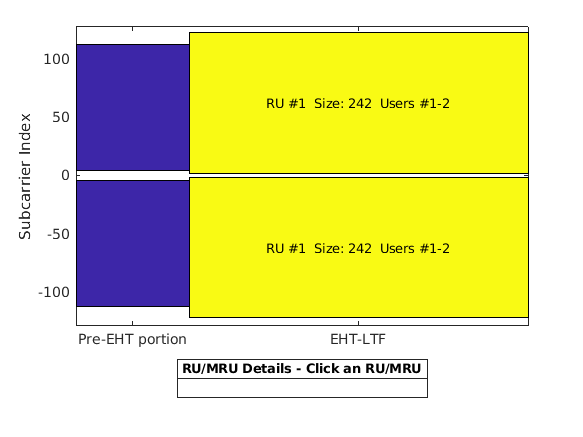

In [40]:
showAllocation(cfgMUMIMO);


In [41]:
% PSDU
psduLen = psduLength(cfgMUMIMO);
psdu = cell(1,allocInfo.NumUsers);
for i = 1:allocInfo.NumUsers
    psdu{i} = randi([0 1],psduLen(i)*8,1,'int8');
end

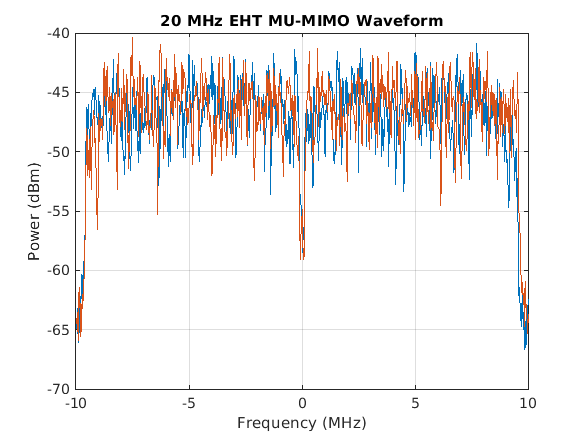

In [42]:
% Generate a 20 MHz non-OFDMA (MU-MIMO) packet with two users.
tx = wlanWaveformGenerator(psdu,cfgMUMIMO);

% sa = plotSpectrumAndSpectrogram(tx,cfgMUMIMO);
% Calculate power spectrum using pwelch
fs = 20e6; % Set sampling frequency based on the channel bandwidth (20 MHz)
[PxxTx, fTx] = pwelch(tx, [], [], [], fs, 'centered');

% Plot the power spectrum in dBm
figure;
plot(fTx/1e6, 10*log10(PxxTx) + 30); % Add 30 to convert dB to dBm
xlabel('Frequency (MHz)');
ylabel('Power (dBm)');
title('20 MHz EHT MU-MIMO Waveform');
grid on;


### IEEE 802.11a WLAN model


This model is a model created by the MATLAB community.

![model](resources/IEEE80211a_model.png)

Here is its [FileExchange](https://ww2.mathworks.cn/matlabcentral/fileexchange/3540-ieee-802-11a-wlan-model) link. You may also find it in the resources folder if you are accessing through *GitHub*.

**BUG!** Cannot compile the Simulink model in R2023a. May due to it is too old.

### 802.11n in Simulink

This example shows how to simulate an IEEE® 802.11n™ HT link in Simulink® with WLAN Toolbox™.

![example](resources/HTLinkModelWLANExample_01.png)

Link is [here](https://ww2.mathworks.cn/help/wlan/ug/802-11n-link-in-simulink.html).

Since it is also a **Simulink** model. The results are present in pictures in Markdown.

The equalized symbols can be shown as:

![Equalized_Symbols](results/80211n-equal-symbols.png)

### Basic VHT Data Recovery


#### Basic Data Recovery

![basic](resources/vht_basic.png)

In [135]:
% Create VHT configuration object.
cfg = wlanVHTConfig;
% Create a VHT transmit waveform by using the VHT configuration object.
txSig = wlanWaveformGenerator([1;0;1;1],cfg); % Data sequence set to [1;0;1;1]
% Pass the received signal through an AWGN channel.
rxSig = awgn(txSig,10);
% Determine the field indices of the waveform.
ind = wlanFieldIndices(cfg);
% Extract the VHT-LTF from the received signal.
rxVHTLTF = rxSig(ind.VHTLTF(1):ind.VHTLTF(2),:);
% Demodulate the VHT-LTF. Estimate the channel response by using the demodulated signal.
demodVHTLTF = wlanVHTLTFDemodulate(rxVHTLTF,cfg);
chEst = wlanVHTLTFChannelEstimate(demodVHTLTF,cfg);
% Extract the VHT data field.
rxData = rxSig(ind.VHTData(1):ind.VHTData(2),:);
% Recover the information bits by using the channel and noise variance estimates.
rxBits = wlanVHTDataRecover(rxData,chEst,0.1,cfg);
rxBits(1:8)



ans = 8x1 int8
   1
   0
   1
   1
   1
   0
   1
   1

#### Data Recovery with Frequency Correction
![freq_corr](resources/vht_freq_corr.png)

In [136]:
% Set the channel bandwidth and sample rate.
cbw = 'CBW160';
fs = 160e6;
% Create a VHT configuration object that supports a 2x2 MIMO transmission.
cfg = wlanVHTConfig('ChannelBandwidth',cbw, ...
    'NumTransmitAntennas',2,'NumSpaceTimeStreams',2);
% Generate a VHT waveform containing a random PSDU.
txPSDU = randi([0 1],cfg.PSDULength*8,1);
txSig = wlanWaveformGenerator(txPSDU,cfg);
% Create a 2x2 TGac channel.
tgacChan = wlanTGacChannel('SampleRate',fs,'ChannelBandwidth',cbw, ...
    'NumTransmitAntennas',2,'NumReceiveAntennas',2);
% Create a phase and frequency offset object.
pfOffset = comm.PhaseFrequencyOffset('SampleRate',fs,'FrequencyOffsetSource','Input port');
% Pass the transmitted waveform through the noisy TGac channel.
rxSigNoNoise = tgacChan(txSig);
rxSig = awgn(rxSigNoNoise,15);
% Introduce a frequency offset of 500 Hz to the received signal.
rxSigFreqOffset = pfOffset(rxSig,500);
% Find the start and stop indices for all component fields of the PPDU.
ind = wlanFieldIndices(cfg);
% Extract the L-STF. Estimate and correct for the carrier frequency offset.
rxLSTF = rxSigFreqOffset(ind.LSTF(1):ind.LSTF(2),:);

foffset1 = wlanCoarseCFOEstimate(rxLSTF,cbw);
rxSig1 = pfOffset(rxSigFreqOffset,-foffset1);
% Extract the L-LTF from the corrected signal. Estimate and correct for the residual frequency offset.
rxLLTF = rxSig1(ind.LLTF(1):ind.LLTF(2),:);

foffset2 = wlanFineCFOEstimate(rxLLTF,cbw);
rxSig2 = pfOffset(rxSig1,-foffset2);
% Extract and demodulate the VHT-LTF. Estimate the channel coefficients.
rxVHTLTF = rxSig2(ind.VHTLTF(1):ind.VHTLTF(2),:);
demodVHTLTF = wlanVHTLTFDemodulate(rxVHTLTF,cfg);
chEst = wlanVHTLTFChannelEstimate(demodVHTLTF,cfg);
% Extract the VHT data field from the received and frequency-corrected PPDU. Recover the data field.
rxData = rxSig2(ind.VHTData(1):ind.VHTData(2),:);
rxPSDU = wlanVHTDataRecover(rxData,chEst,0.03,cfg);
% Calculate the number of bit errors in the received packet.
numErr = biterr(txPSDU,rxPSDU)


numErr = 
   7

### Introduction to MIMO Systems

#### Part 1: Transmit Diversity vs. Receive Diversity

In [137]:
%% https://ww2.mathworks.cn/help/comm/ug/introduction-to-mimo-systems.html?searchHighlight=alamouti&s_tid=srchtitle_alamouti_5
% Define simulation parameters
frmLen = 100;       % frame length
numPackets = 1000;  % number of packets
EbNo = 0:2:20;      % Eb/No varying to 20 dB
N = 2;              % maximum number of Tx antennas
M = 2;              % maximum number of Rx antennas
% Setup the simulation
% Create comm.BPSKModulator and comm.BPSKDemodulator System objects(TM)
P = 2;				% modulation order
bpskMod = comm.BPSKModulator;
bpskDemod = comm.BPSKDemodulator('OutputDataType','double');

% Create comm.OSTBCEncoder and comm.OSTBCCombiner System objects
ostbcEnc = comm.OSTBCEncoder;
ostbcComb = comm.OSTBCCombiner;

% Convert Eb/No values to SNR values. The output of the BPSK modulator
% generates unit power signals.
SNR = convertSNR(EbNo,"ebno","BitsPerSymbol",1);

% Create comm.ErrorRate calculator System objects to evaluate BER.
errorCalc1 = comm.ErrorRate;
errorCalc2 = comm.ErrorRate;
errorCalc3 = comm.ErrorRate;

% Since the AWGN function as well as the RANDI function use the default
% random stream, the following commands are executed so that the results
% will be repeatable, i.e., same results will be obtained for every run of
% the example. The default stream will be restored at the end of the
% example.
s = rng(55408);

% Pre-allocate variables for speed
H = zeros(frmLen, N, M);
ber_noDiver  = zeros(3,length(EbNo));
ber_Alamouti = zeros(3,length(EbNo));
ber_MaxRatio = zeros(3,length(EbNo));
ber_thy2     = zeros(1,length(EbNo));

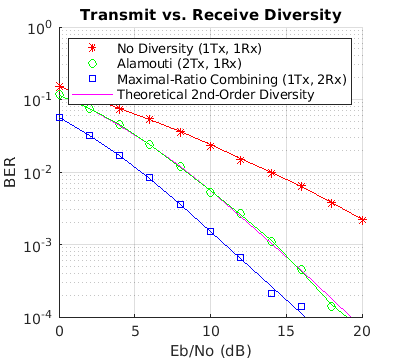

In [138]:
% Set up a figure for visualizing BER results
fig = figure;
grid on;
ax = fig.CurrentAxes;
hold(ax,'on');

ax.YScale = 'log';
xlim(ax,[EbNo(1), EbNo(end)]);
ylim(ax,[1e-4 1]);
xlabel(ax,'Eb/No (dB)');
ylabel(ax,'BER');
fig.NumberTitle = 'off';
fig.Renderer = 'zbuffer';
fig.Name = 'Transmit vs. Receive Diversity';
title(ax,'Transmit vs. Receive Diversity');
set(fig, 'DefaultLegendAutoUpdate', 'off');
fig.Position = figposition([15 50 25 30]);

% Loop over several EbNo points
for idx = 1:length(EbNo)
    reset(errorCalc1);
    reset(errorCalc2);
    reset(errorCalc3);
    % Loop over the number of packets
    for packetIdx = 1:numPackets
        % Generate data vector per frame
        data = randi([0 P-1], frmLen, 1);

        % Modulate data
        modData = bpskMod(data);

        % Alamouti Space-Time Block Encoder
        encData = ostbcEnc(modData);

        % Create the Rayleigh distributed channel response matrix
        %   for two transmit and two receive antennas
        H(1:N:end, :, :) = (randn(frmLen/2, N, M) + ...
                         1i*randn(frmLen/2, N, M))/sqrt(2);
        %   assume held constant for 2 symbol periods
        H(2:N:end, :, :) = H(1:N:end, :, :);

        % Extract part of H to represent the 1x1, 2x1 and 1x2 channels
        H11 = H(:,1,1);
        H21 = H(:,:,1)/sqrt(2);
        H12 = squeeze(H(:,1,:));

        % Pass through the channels
        chanOut11 = H11 .* modData;
        chanOut21 = sum(H21.* encData, 2);
        chanOut12 = H12 .* repmat(modData, 1, 2);

        % Add AWGN
        rxSig11 = awgn(chanOut11,SNR(idx));
        rxSig21 = awgn(chanOut21,SNR(idx));
        rxSig12 = awgn(chanOut12,SNR(idx));

        % Alamouti Space-Time Block Combiner
        decData = ostbcComb(rxSig21, H21);

        % ML Detector (minimum Euclidean distance)
        demod11 = bpskDemod(rxSig11.*conj(H11));
        demod21 = bpskDemod(decData);
        demod12 = bpskDemod(sum(rxSig12.*conj(H12), 2));

        % Calculate and update BER for current EbNo value
        %   for uncoded 1x1 system
        ber_noDiver(:,idx)  = errorCalc1(data, demod11);
        %   for Alamouti coded 2x1 system
        ber_Alamouti(:,idx) = errorCalc2(data, demod21);
        %   for Maximal-ratio combined 1x2 system
        ber_MaxRatio(:,idx) = errorCalc3(data, demod12);

    end % end of FOR loop for numPackets

    % Calculate theoretical second-order diversity BER for current EbNo
    ber_thy2(idx) = berfading(EbNo(idx), 'psk', 2, 2);

    % Plot results
    semilogy(ax,EbNo(1:idx), ber_noDiver(1,1:idx), 'r*', ...
             EbNo(1:idx), ber_Alamouti(1,1:idx), 'go', ...
             EbNo(1:idx), ber_MaxRatio(1,1:idx), 'bs', ...
             EbNo(1:idx), ber_thy2(1:idx), 'm');
    legend(ax,'No Diversity (1Tx, 1Rx)', 'Alamouti (2Tx, 1Rx)',...
           'Maximal-Ratio Combining (1Tx, 2Rx)', ...
           'Theoretical 2nd-Order Diversity');

    drawnow;
end  % end of for loop for EbNo

% Perform curve fitting and replot the results
fitBER11 = berfit(EbNo, ber_noDiver(1,:));
fitBER21 = berfit(EbNo, ber_Alamouti(1,:));
fitBER12 = berfit(EbNo, ber_MaxRatio(1,:));
semilogy(ax,EbNo, fitBER11, 'r', EbNo, fitBER21, 'g', EbNo, fitBER12, 'b');
hold(ax,'off');

% Restore default stream
rng(s);

#### Part 2: Space-Time Block Coding with Channel Estimation


In [139]:
% Define simulation parameters
frmLen = 100;           % frame length
maxNumErrs = 300;       % maximum number of errors
maxNumPackets = 3000;   % maximum number of packets
EbNo = 0:2:12;          % Eb/No varying to 12 dB
N = 2;                  % number of Tx antennas
M = 2;                  % number of Rx antennas
pLen = 8;               % number of pilot symbols per frame
W = hadamard(pLen);
pilots = W(:, 1:N);     % orthogonal set per transmit antenna

% Setup the simulation
% Create a comm.MIMOChannel System object to simulate the 2x2 spatially
% independent flat-fading Rayleigh channel
chan = comm.MIMOChannel( ...
    'MaximumDopplerShift', 0, ...
    'SpatialCorrelationSpecification', 'None', ...
    'NumTransmitAntennas', N, ...
    'NumReceiveAntennas', M, ...
    'PathGainsOutputPort', true);

% Change the NumReceiveAntennas property value of the hAlamoutiDec System
% object to M that is 2
release(ostbcComb);
ostbcComb.NumReceiveAntennas = M;

% Set the global random stream for repeatability
s = rng(55408);

% Pre-allocate variables for speed
HEst = zeros(frmLen, N, M);
ber_Estimate = zeros(3,length(EbNo));
ber_Known    = zeros(3,length(EbNo));

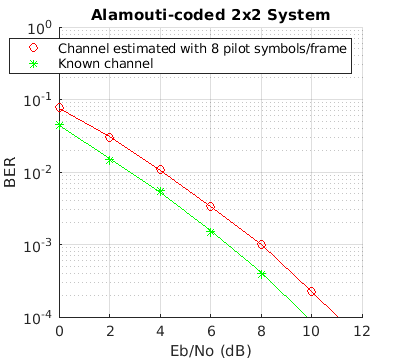

In [140]:
% Set up a figure for visualizing BER results
fig = figure;
grid on;
ax = fig.CurrentAxes;
hold(ax,'on');

ax.YScale = 'log';
xlim(ax,[EbNo(1), EbNo(end)]);
ylim(ax,[1e-4 1]);
xlabel(ax,'Eb/No (dB)');
ylabel(ax,'BER');
fig.NumberTitle = 'off';
fig.Name = 'Orthogonal Space-Time Block Coding';
fig.Renderer = 'zbuffer';
title(ax,'Alamouti-coded 2x2 System');
set(fig,'DefaultLegendAutoUpdate','off');
fig.Position = figposition([41 50 25 30]);

% Loop over several EbNo points
for idx = 1:length(EbNo)
    reset(errorCalc1);
    reset(errorCalc2);

    % Loop till the number of errors exceed 'maxNumErrs'
    % or the maximum number of packets have been simulated
    while (ber_Estimate(2,idx) < maxNumErrs) && ...
          (ber_Known(2,idx) < maxNumErrs) && ...
          (ber_Estimate(3,idx)/frmLen < maxNumPackets)
        % Generate data vector per frame
        data = randi([0 P-1], frmLen, 1);

        % Modulate data
        modData = bpskMod(data);

        % Alamouti Space-Time Block Encoder
        encData = ostbcEnc(modData);

        % Prepend pilot symbols for each frame
        txSig = [pilots; encData];

        % Pass through the 2x2 channel
        reset(chan);
        [chanOut, H] = chan(txSig);

        % Add AWGN
        rxSig = awgn(chanOut,SNR(idx));

        % Channel Estimation
        %   For each link => N*M estimates
        HEst(1,:,:) = pilots(:,:).' * rxSig(1:pLen, :) / pLen;
        %   assume held constant for the whole frame
        HEst = HEst(ones(frmLen, 1), :, :);

        % Combiner using estimated channel
        decDataEst = ostbcComb(rxSig(pLen+1:end,:), HEst);

        % Combiner using known channel
        decDataKnown = ostbcComb(rxSig(pLen+1:end,:), ...
                            squeeze(H(pLen+1:end,:,:,:)));

        % ML Detector (minimum Euclidean distance)
        demodEst   = bpskDemod(decDataEst);      % estimated
        demodKnown = bpskDemod(decDataKnown);    % known

        % Calculate and update BER for current EbNo value
        %   for estimated channel
        ber_Estimate(:,idx) = errorCalc1(data, demodEst);
        %   for known channel
        ber_Known(:,idx)    = errorCalc2(data, demodKnown);

    end % end of FOR loop for numPackets

    % Plot results
    semilogy(ax,EbNo(1:idx), ber_Estimate(1,1:idx), 'ro');
    semilogy(ax,EbNo(1:idx), ber_Known(1,1:idx), 'g*');
    legend(ax,['Channel estimated with ' num2str(pLen) ' pilot symbols/frame'],...
           'Known channel');
    drawnow;
end  % end of for loop for EbNo

% Perform curve fitting and replot the results
fitBEREst   = berfit(EbNo, ber_Estimate(1,:));
fitBERKnown = berfit(EbNo, ber_Known(1,:));
semilogy(ax,EbNo, fitBEREst, 'r', EbNo, fitBERKnown, 'g');
hold(ax,'off');

% Restore default stream
rng(s)

#### Part 3: Orthogonal Space-Time Block Coding and Further Explorations


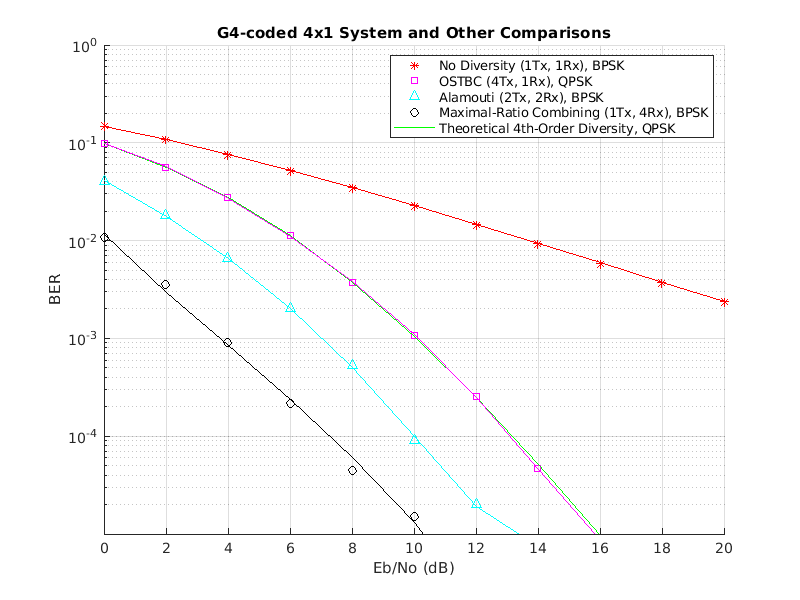

In [149]:
[licensePCT,~] = license( 'checkout' , 'Distrib_Computing_Toolbox');
if (licensePCT && ~isempty(ver('parallel')))
    EbNo = 0:2:20;
    [ber11, ber14, ber22, ber41] = mimoOSTBCWithPCT(100,4e3,EbNo);
else
    load ostbcRes.mat;
end

% Set up a figure for visualizing BER results
fig = figure;
grid on;
ax = fig.CurrentAxes;
hold(ax,'on');
fig.Renderer  = 'zbuffer';
ax.YScale = 'log';
xlim(ax,[EbNo(1), EbNo(end)]);
ylim(ax,[1e-5 1]);
xlabel(ax,'Eb/No (dB)');
ylabel(ax,'BER');
fig.NumberTitle = 'off';
fig.Name = 'Orthogonal Space-Time Block Coding(2)';
title(ax,'G4-coded 4x1 System and Other Comparisons');
set(fig,'DefaultLegendAutoUpdate','off');

% Enlarge the figure and adjust its position
fig.Position = [100 100 800 600]; % [left bottom width height]

% Plot results
semilogy(ax,EbNo, ber11, 'r*', EbNo, ber41, 'ms', EbNo, ber22, 'c^', ...
         EbNo, ber14, 'ko', EbNo, BERthy4, 'g');

% Set the legend location
lgd = legend(ax,'No Diversity (1Tx, 1Rx), BPSK', 'OSTBC (4Tx, 1Rx), QPSK', ...
       'Alamouti (2Tx, 2Rx), BPSK', 'Maximal-Ratio Combining (1Tx, 4Rx), BPSK', ...
       'Theoretical 4th-Order Diversity, QPSK');
lgd.Location = 'northeast';

% Perform curve fitting
fitBER11 = berfit(EbNo, ber11);
fitBER41 = berfit(EbNo(1:9), ber41(1:9));
fitBER22 = berfit(EbNo(1:8), ber22(1:8));
fitBER14 = berfit(EbNo(1:7), ber14(1:7));
semilogy(ax,EbNo, fitBER11, 'r', EbNo(1:9), fitBER41, 'm', ...
         EbNo(1:8), fitBER22, 'c', EbNo(1:7), fitBER14, 'k');
hold(ax,'off');


### Spatial Multiplexing


In [146]:
%% https://ww2.mathworks.cn/help/comm/ug/spatial-multiplexing.html
%% Simulation
% parameters
N = 2;                  % Number of transmit antennas
M = 2;                  % Number of receive antennas
EbNoVec = 2:3:8;        % Eb/No in dB
modOrd = 2;             % constellation size = 2^modOrd
% Setup
% Create a local random stream to be used by random number generators for
% repeatability.
stream = RandStream('mt19937ar');

% Create PSK modulator and demodulator System objects
pskModulator   = comm.PSKModulator(...
            'ModulationOrder',  2^modOrd, ...
            'PhaseOffset',      0, ...
            'BitInput',         true);
pskDemodulator = comm.PSKDemodulator( ...
            'ModulationOrder',  2^modOrd, ...
            'PhaseOffset',      0, ...
            'BitOutput',        true);

% Calculate SNR from EbNo for each independent transmission link
snrIndB = convertSNR(EbNoVec,'ebno','BitsPerSymbol',modOrd);
snrLinear = 10.^(0.1*snrIndB);

% Create error rate calculation System objects for 3 different receivers
zfBERCalc = comm.ErrorRate;
mmseBERCalc = comm.ErrorRate;
mlBERCalc = comm.ErrorRate;

% Get all bit and symbol combinations for ML receiver
allBits = int2bit(0:2^(modOrd*N)-1, modOrd*N);
allTxSig = reshape(pskModulator(allBits(:)), N, 2^(modOrd*N));

% Pre-allocate variables to store BER results for speed
[BER_ZF, BER_MMSE, BER_ML] = deal(zeros(length(EbNoVec), 3));


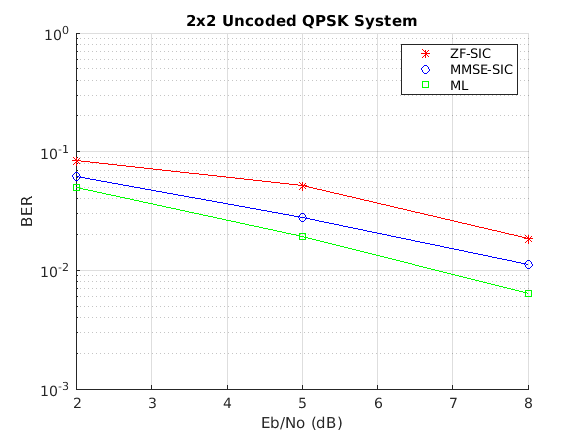

In [147]:
% Set up a figure for visualizing BER results
fig = figure;
grid on;
hold on;
ax = fig.CurrentAxes;
ax.YScale = 'log';
xlim([EbNoVec(1)-0.01 EbNoVec(end)]);
ylim([1e-3 1]);
xlabel('Eb/No (dB)');
ylabel('BER');
fig.NumberTitle = 'off';
fig.Renderer = 'zbuffer';
fig.Name = 'Spatial Multiplexing';
title('2x2 Uncoded QPSK System');
set(fig,'DefaultLegendAutoUpdate','off');

% Loop over selected EbNo points
for idx = 1:length(EbNoVec)
    % Reset error rate calculation System objects
    reset(zfBERCalc);
    reset(mmseBERCalc);
    reset(mlBERCalc);

    while (BER_ZF(idx, 3) < 1e5) && ((BER_MMSE(idx, 2) < 100) || ...
          (BER_ZF(idx, 2) < 100) ||  (BER_ML(idx, 2)   < 100))
        % Create random bit vector to modulate
        msg = randi(stream, [0 1], [N*modOrd, 1]);

        % Modulate data
        txSig = pskModulator(msg);

        % Flat Rayleigh fading channel with independent links
        rayleighChan = (randn(stream, M, N) +  1i*randn(stream, M, N))/sqrt(2);

        % Add noise to faded data
        rxSig = awgn(rayleighChan*txSig, snrIndB(idx), 0, stream);

        % ZF-SIC receiver
        r = rxSig;
        H = rayleighChan; % Assume perfect channel estimation
        % Initialization
        estZF = zeros(N*modOrd, 1);
        orderVec = 1:N;
        k = N+1;
        % Start ZF nulling loop
        for n = 1:N
            % Shrink H to remove the effect of the last decoded symbol
            H = H(:, [1:k-1,k+1:end]);
            % Shrink order vector correspondingly
            orderVec = orderVec(1, [1:k-1,k+1:end]);
            % Select the next symbol to be decoded
            G = (H'*H) \ eye(N-n+1); % Same as inv(H'*H), but faster
            [~, k] = min(diag(G));
            symNum = orderVec(k);

            % Hard decode the selected symbol
            decBits = pskDemodulator(G(k,:) * H' * r);
            estZF(modOrd * (symNum-1) + (1:modOrd)) = decBits;

            % Subtract the effect of the last decoded symbol from r
            if n < N
                r = r - H(:, k) * pskModulator(decBits);
            end
        end

        % MMSE-SIC receiver
        r = rxSig;
        H = rayleighChan;
        % Initialization
        estMMSE = zeros(N*modOrd, 1);
        orderVec = 1:N;
        k = N+1;
        % Start MMSE nulling loop
        for n = 1:N
            H = H(:, [1:k-1,k+1:end]);
            orderVec = orderVec(1, [1:k-1,k+1:end]);
            % Order algorithm (matrix G calculation) is the only difference
            % with the ZF-SIC receiver
            G = (H'*H + ((N-n+1)/snrLinear(idx))*eye(N-n+1)) \ eye(N-n+1);
            [~, k] = min(diag(G));
            symNum = orderVec(k);

            decBits = pskDemodulator(G(k,:) * H' * r);
            estMMSE(modOrd * (symNum-1) + (1:modOrd)) = decBits;

            if n < N
                r = r - H(:, k) * pskModulator(decBits);
            end
        end

        % ML receiver
        r = rxSig;
        H = rayleighChan;
        [~, k] = min(sum(abs(repmat(r,[1,2^(modOrd*N)]) - H*allTxSig).^2));
        estML = allBits(:,k);

        % Update BER
        BER_ZF(  idx, :) = zfBERCalc(msg, estZF);
        BER_MMSE(idx, :) = mmseBERCalc(msg, estMMSE);
        BER_ML(  idx, :) = mlBERCalc(msg, estML);
    end

    % Plot results
    semilogy(EbNoVec(1:idx), BER_ZF(  1:idx, 1), 'r*', ...
             EbNoVec(1:idx), BER_MMSE(1:idx, 1), 'bo', ...
             EbNoVec(1:idx), BER_ML(  1:idx, 1), 'gs');
    legend('ZF-SIC', 'MMSE-SIC', 'ML');
    drawnow;
end

% Draw the lines
semilogy(EbNoVec, BER_ZF(  :, 1), 'r-', ...
         EbNoVec, BER_MMSE(:, 1), 'b-', ...
         EbNoVec, BER_ML(  :, 1), 'g-');
hold off;


### Apply OFDM in MIMO Simulation


In [153]:
%% https://ww2.mathworks.cn/help/comm/ug/ofdm-with-mimo-simulation.html
% Create an OFDM modulator and demodulator pair with user-specified pilot indices, 
% an inserted DC null, two transmit antennas, and two receive antennas. 
% Specify pilot indices that vary across antennas.
ofdmMod = comm.OFDMModulator(FFTLength=128, ...
    PilotInputPort=true, ...
    PilotCarrierIndices= ...
    cat(3,[12; 40; 54; 76; 90; 118],[13; 39; 55; 75; 91; 117]), ...
    InsertDCNull=true, ...
    NumTransmitAntennas=2);
ofdmDemod = comm.OFDMDemodulator(ofdmMod);
ofdmDemod.NumReceiveAntennas = 2;



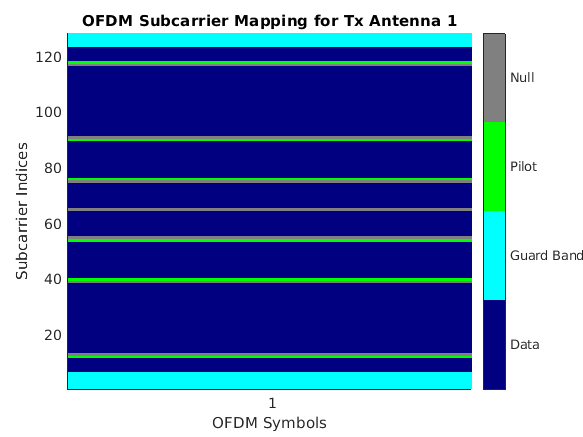

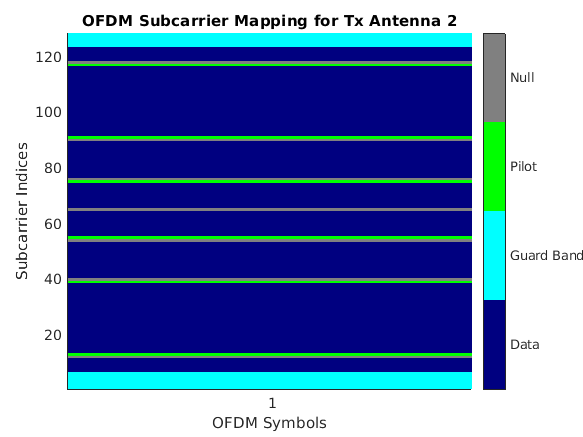

In [154]:
%Show the resource mapping of pilot subcarriers for each transmit antenna.
showResourceMapping(ofdmMod)


In [155]:
% Determine the dimensions of the OFDM modulator by using the info method.

ofdmModDim = info(ofdmMod);
numData = ofdmModDim.DataInputSize(1);  % Number of data subcarriers
numSym = ofdmModDim.DataInputSize(2);   % Number of OFDM symbols
numTxAnt = ofdmModDim.DataInputSize(3); % Number of transmit antennas

% Generate data symbols to fill 100 OFDM frames.

nframes = 100;
M = 4; % Modulation order to QPSK
data = randi([0 M-1],nframes*numData,numSym,numTxAnt);

% Apply QPSK modulation to the random symbols and reshape the resulting column vector to match the OFDM modulator requirements.

modData = pskmod(data(:),M,pi/4);
modData = reshape(modData,nframes*numData,numSym,numTxAnt);

% Create an error rate counter.

errorRate = comm.ErrorRate;


In [156]:
% Simulate the OFDM system over 100 frames assuming a flat, 2x2, Rayleigh fading channel. 
% Remove the effects of multipath fading using a simple, least squares solution, 
% and demodulate the OFDM waveform and QPSK data. 
% Generate error statistics by comparing the original data with the demodulated data.
for k = 1:nframes

    % Find row indices for kth OFDM frame
    indData = (k-1)*ofdmModDim.DataInputSize(1)+1:k*numData;

    % Generate random OFDM pilot symbols
    pilotData = complex(rand(ofdmModDim.PilotInputSize), ...
        rand(ofdmModDim.PilotInputSize));

    % Modulate QPSK symbols using OFDM
    dataOFDM = ofdmMod(modData(indData,:,:),pilotData);

    % Create flat, i.i.d., Rayleigh fading channel 2-by-2 channel
    chGain = complex(randn(2,2),randn(2,2))/sqrt(2); 

    % Pass OFDM signal through Rayleigh and AWGN channels
    receivedSignal = awgn(dataOFDM*chGain,30);

    % Apply least squares solution to remove effects of fading channel
    rxSigMF = chGain.' \ receivedSignal.';

    % Demodulate OFDM data
    receivedOFDMData = ofdmDemod(rxSigMF.');

    % Demodulate QPSK data
    receivedData = pskdemod(receivedOFDMData(:),M,pi/4);

    % Compute error statistics
    dataTmp = data(indData,:,:);
    errors = errorRate(dataTmp(:),receivedData);
end




In [157]:
% Display the error statistics.

fprintf('\nSymbol error rate = %d from %d errors in %d symbols\n',errors)



Symbol error rate = 9.668269e-02 from 2011 errors in 20800 symbols


### 802.11ac Multiuser MIMO Precoding with WINNER II Channel Model
![model](resources/winner_ii.png)

In [1]:
%% https://ww2.mathworks.cn/help/comm/ug/802-11ac-multi-user-mimo-precoding-with-winner-ii-channel-model.html
%% Check for Support Package Installation
commSupportPackageCheck('CST_WINNER2');

In [2]:
%% Simulation Parameters and Configuration
s = rng(10);                           % Set RNG seed for repeatability

% Transmission parameters
chanBW      = 'CBW80';               % Channel bandwidth
numUsers    = 3;                     % Number of users
numSTSVec   = [3 1 4];               % Number of streams per user
userPos     = [0 1 2];               % User positions
mcsVec      = [4 6 8];               % MCS per user: 16QAM, 64QAM, 256QAM
apepVec     = [520 192 856];         % Payload per user, in bytes
chCodingVec = {'BCC','LDPC','LDPC'}; % Channel coding per user

% Precoding and equalization parameters
precodingType = 'ZF';                % Precoding type; ZF or MMSE
snr           = 47;                  % SNR in dB
eqMethod      = 'ZF';                % Equalization method

% Create the multiuser VHT format configuration object
numTx = sum(numSTSVec);
cfgVHTMU = wlanVHTConfig('ChannelBandwidth',chanBW, ...
    'NumUsers',numUsers, ...
    'NumTransmitAntennas',numTx, ...
    'GroupID',2, ...
    'NumSpaceTimeStreams',numSTSVec,...
    'UserPositions',userPos, ...
    'MCS',mcsVec, ...
    'APEPLength',apepVec, ...
    'ChannelCoding',chCodingVec);

In [3]:
%% Sounding (NDP) Configuration
% VHT sounding (NDP) configuration, for same number of streams
cfgVHTNDP = wlanVHTConfig('ChannelBandwidth',chanBW, ...
    'NumUsers',1, ...
    'NumTransmitAntennas',numTx, ...
    'GroupID',0, ...
    'NumSpaceTimeStreams',sum(numSTSVec),...
    'MCS',0, ...
    'APEPLength',0);

% Generate the null data packet, with no data
txNDPSig = wlanWaveformGenerator([],cfgVHTNDP);
NPDSigLen = size(txNDPSig, 1);

In [4]:
%% WINNER II Channel for Indoor Office (A1) Scenario
% Set up layout parameters for WINNER II channel
AA = winner2.AntennaArray('UCA',numTx,0.2);
for i = 1:numUsers
    AA(i+1) = winner2.AntennaArray('ULA',numSTSVec(i),0.05);
end
STAIdx   = 2:(numUsers+1);
APIdx   = {1};
rndSeed = 12;
cfgLayout = winner2.layoutparset(STAIdx,APIdx,numUsers,AA,[],rndSeed);
cfgLayout.Pairing = [ones(1,numUsers);2:(numUsers+1)]; % One access point to all users
cfgLayout.ScenarioVector = ones(1,numUsers);           % A1 scenario for all links
cfgLayout.PropagConditionVector = zeros(1,numUsers);  % NLOS
for i = 1:numUsers % Randomly set velocity for each user
    v = rand(3,1) - 0.5;
    cfgLayout.Stations(i+1).Velocity = v/norm(v,'fro');
end

% Set up model parameters for WINNER II channel
cfgModel = winner2.wimparset;
cfgModel.FixedPdpUsed       = 'yes';
cfgModel.FixedAnglesUsed    = 'yes';
cfgModel.IntraClusterDsUsed = 'no';
cfgModel.RandomSeed         = 111;    % Repeatability

% The maximum velocity for the 3 users is 1m/s. Set up the SampleDensity
% field to ensure that the sample rate matches the channel bandwidth.
maxMSVelocity = max(cell2mat(cellfun(@(x) norm(x,'fro'), ...
    {cfgLayout.Stations.Velocity},'UniformOutput',false)));
cfgModel.UniformTimeSampling = 'yes';
cfgModel.SampleDensity = round(physconst('LightSpeed')/ ...
    cfgModel.CenterFrequency/2/(maxMSVelocity/wlanSampleRate(cfgVHTMU)));

% Create the WINNER II channel System object
WINNERChan = comm.WINNER2Channel(cfgModel,cfgLayout);

% Call the info method to check some derived channel parameters
chanInfo = info(WINNERChan)

chanInfo = struct with fields:
   NumLinks: 3
          NumBSElements: [8 8 8]
          NumMSElements: [3 1 4]
               NumPaths: [16 16 16]
             SampleRate: [8.0000e+07 8.0000e+07 8.0000e+07]
     ChannelFilterDelay: [7 7 7]
    NumSamplesProcessed: 0

In [5]:
chanDelay   = chanInfo.ChannelFilterDelay;
numPadZeros = 10;

% Set ModelConfig.NumTimeSamples to match the length of the input signal to
% avoid warning
WINNERChan.ModelConfig.NumTimeSamples = NPDSigLen + numPadZeros;

% Sound the WINNER II channel for all users
chanOutNDP = WINNERChan([txNDPSig;zeros(numPadZeros,numTx)]);

% Add AWGN
rxNDPSig = cellfun(@awgn,chanOutNDP, ...
    num2cell(snr*ones(numUsers,1)),'UniformOutput',false);

In [6]:
%% Channel State Information Feedback
mat = cell(numUsers,1);
for uIdx = 1:numUsers
    % Compute the feedback matrix based on received signal per user
    mat{uIdx} = vhtCSIFeedback(rxNDPSig{uIdx}(chanDelay(uIdx)+1:end,:), ...
        cfgVHTNDP,uIdx,numSTSVec);
end
% Pack the per user CSI into a matrix
numST = length(mat{1});         % Number of subcarriers
steeringMatrix = zeros(numST,sum(numSTSVec),sum(numSTSVec));
%   Nst-by-Nt-by-Nsts
for uIdx = 1:numUsers
    stsIdx = sum(numSTSVec(1:uIdx-1))+(1:numSTSVec(uIdx));
    steeringMatrix(:,:,stsIdx) = mat{uIdx};     % Nst-by-Nt-by-Nsts
end

% Zero-forcing or MMSE precoding solution
if strcmp(precodingType, 'ZF')
    delta = 0; % Zero-forcing
else
    delta = (numTx/(10^(snr/10))) * eye(numTx); % MMSE
end
for i = 1:numST
    % Channel inversion precoding
    h = squeeze(steeringMatrix(i,:,:));
    steeringMatrix(i,:,:) = h/(h'*h + delta);
end

% Set the spatial mapping based on the steering matrix
cfgVHTMU.SpatialMapping = 'Custom';
cfgVHTMU.SpatialMappingMatrix = permute(steeringMatrix,[1 3 2]);

In [7]:
%% Data Transimission
% Create data sequences, one for each user
txDataBits = cell(numUsers,1);
psduDataBits = cell(numUsers,1);
for uIdx = 1:numUsers
    % Generate payload for each user
    txDataBits{uIdx} = randi([0 1],cfgVHTMU.APEPLength(uIdx)*8,1,'int8');

    % Pad payload with zeros to form a PSDU
    psduDataBits{uIdx} = [txDataBits{uIdx}; ...
        zeros((cfgVHTMU.PSDULength(uIdx)-cfgVHTMU.APEPLength(uIdx))*8,1,'int8')];
end
% Create the VHT data packet
txSig = wlanWaveformGenerator(psduDataBits,cfgVHTMU);


In [8]:
release(WINNERChan);

% Set ModelConfig.NumTimeSamples to match the total length of NDP plus
% waveform and padded zeros
WINNERChan.ModelConfig.NumTimeSamples = ...
    WINNERChan.ModelConfig.NumTimeSamples + length(txSig) + numPadZeros;

% Transmit through the WINNER II channel for all users, with 10 all-zero
% samples appended to account for channel filter delay
chanOut = WINNERChan([txNDPSig; zeros(numPadZeros,numTx); ...
    txSig; zeros(numPadZeros,numTx)]);

% Extract the waveform output for each user
chanOut = cellfun(@(x) x(NPDSigLen+numPadZeros+1:end,:),chanOut,'UniformOutput',false);

% Add AWGN
rxSig = cellfun(@awgn,chanOut, ...
    num2cell(snr*ones(numUsers,1)),'UniformOutput',false);

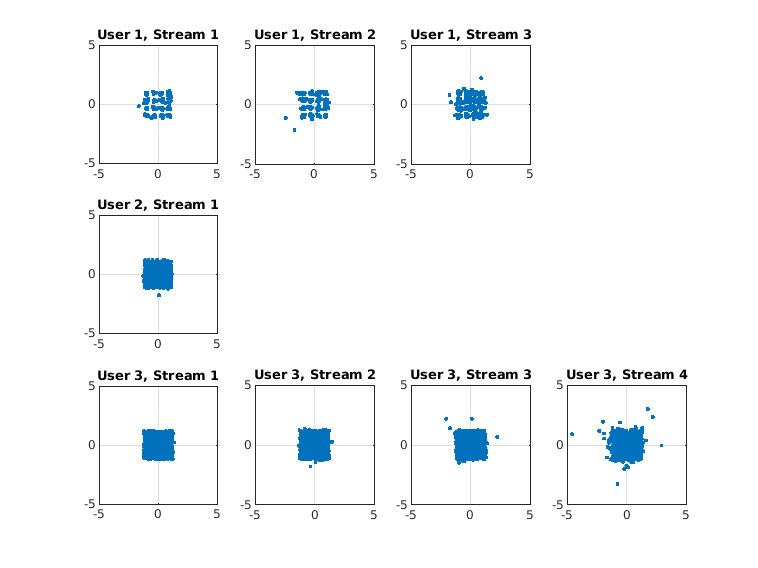

In [9]:
%% Data Recovery per User
% Get field indices from configuration, assumed known at receiver
ind = wlanFieldIndices(cfgVHTMU);

% Single-user receivers recover payload bits
rxDataBits = cell(numUsers,1);
scaler = zeros(numUsers,1);
spAxes = gobjects(sum(numSTSVec),1);
hfig = figure('Name','Per-stream equalized symbol constellation');
for uIdx = 1:numUsers
    rxNSig = rxSig{uIdx}(chanDelay(uIdx)+1:end, :);

    % User space-time streams
    stsU = numSTSVec(uIdx);

    % Estimate noise power in VHT fields
    lltf = rxNSig(ind.LLTF(1):ind.LLTF(2),:);
    demodLLTF = wlanLLTFDemodulate(lltf,chanBW);
    nVar = helperNoiseEstimate(demodLLTF,chanBW,sum(numSTSVec));

    % Perform channel estimation based on VHT-LTF
    rxVHTLTF  = rxNSig(ind.VHTLTF(1):ind.VHTLTF(2),:);
    demodVHTLTF = wlanVHTLTFDemodulate(rxVHTLTF,chanBW,numSTSVec);
    chanEst = wlanVHTLTFChannelEstimate(demodVHTLTF,chanBW,numSTSVec);

    % Recover information bits in VHT Data field
    rxVHTData = rxNSig(ind.VHTData(1):ind.VHTData(2),:);
    [rxDataBits{uIdx},~,eqsym] = wlanVHTDataRecover(rxVHTData, ...
        chanEst,nVar,cfgVHTMU,uIdx, ...
        'EqualizationMethod',eqMethod,'PilotPhaseTracking','None', ...
        'LDPCDecodingMethod','layered-bp','MaximumLDPCIterationCount',6);

    % Plot equalized symbols for all streams per user
    scaler(uIdx) = ceil(max(abs([real(eqsym(:)); imag(eqsym(:))])));
    for i = 1:stsU
        subplot(numUsers,max(numSTSVec),(uIdx-1)*max(numSTSVec)+i);
        plot(reshape(eqsym(:,:,i),[],1),'.');
        axis square
        spAxes(sum([0 numSTSVec(1:(uIdx-1))])+i) = gca; % Store axes handle
        title(['User ' num2str(uIdx) ', Stream ' num2str(i)]);
        grid on;
    end
end

% Scale axes for all subplots and scale figure
for i = 1:numel(spAxes)
    xlim(spAxes(i),[-max(scaler) max(scaler)]);
    ylim(spAxes(i),[-max(scaler) max(scaler)]);
end
pos = get(hfig,'Position');
set(hfig,'Position',[pos(1)*0.7 pos(2)*0.7 1.3*pos(3) 1.3*pos(4)]);

In [10]:
% Compare recovered bits against per-user APEPLength information bits
ber = inf(1, numUsers);
for uIdx = 1:numUsers
    idx = (1:cfgVHTMU.APEPLength(uIdx)*8).';
    [~,ber(uIdx)] = biterr(txDataBits{uIdx}(idx),rxDataBits{uIdx}(idx));
    disp(['Bit Error Rate for User ' num2str(uIdx) ': ' num2str(ber(uIdx))]);
end

rng(s); % Restore RNG state

Bit Error Rate for User 1: 0
Bit Error Rate for User 2: 0
Bit Error Rate for User 3: 0.00014603
